# Logistic regression with Python: `bambi`, `pymc`, `arviz`, and `loo`

This workshop's goal—which is facilitated by this notebook—is to give attendees the confidence to conduct Bayesian regression analyses with `Python` for their research projects.

[`bambi`](https://bambinos.github.io/bambi/) is a high-level Bayesian model-building interface written in `Python`.

[`pymc`](https://www.pymc.io/welcome.html) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process.

[`arviz`](https://python.arviz.org/en/stable/index.html) is a `Python` package for exploratory analysis of Bayesian models.

[`loo`](https://mc-stan.org/loo/index.html) allows users to compute efficient approximate leave-one-out cross-validation for fitted Bayesian models, as well as model weights that can be used to average predictive distributions.

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html) and go through the various steps of conducting regression analyses in a [Bayesian workflow](https://arxiv.org/abs/2011.01808). Hopefully, you will come away feeling confident you can use `Python` to conduct regression analyses for your research projects.

# Table of Contents

## Logistic regression with [`bambi`](https://bambinos.github.io/bambi/)

- ### An intercept

- ### A binary predictor

- ### A continuous predictor

- ### Two predictors (no interaction)

- ### Model comparison

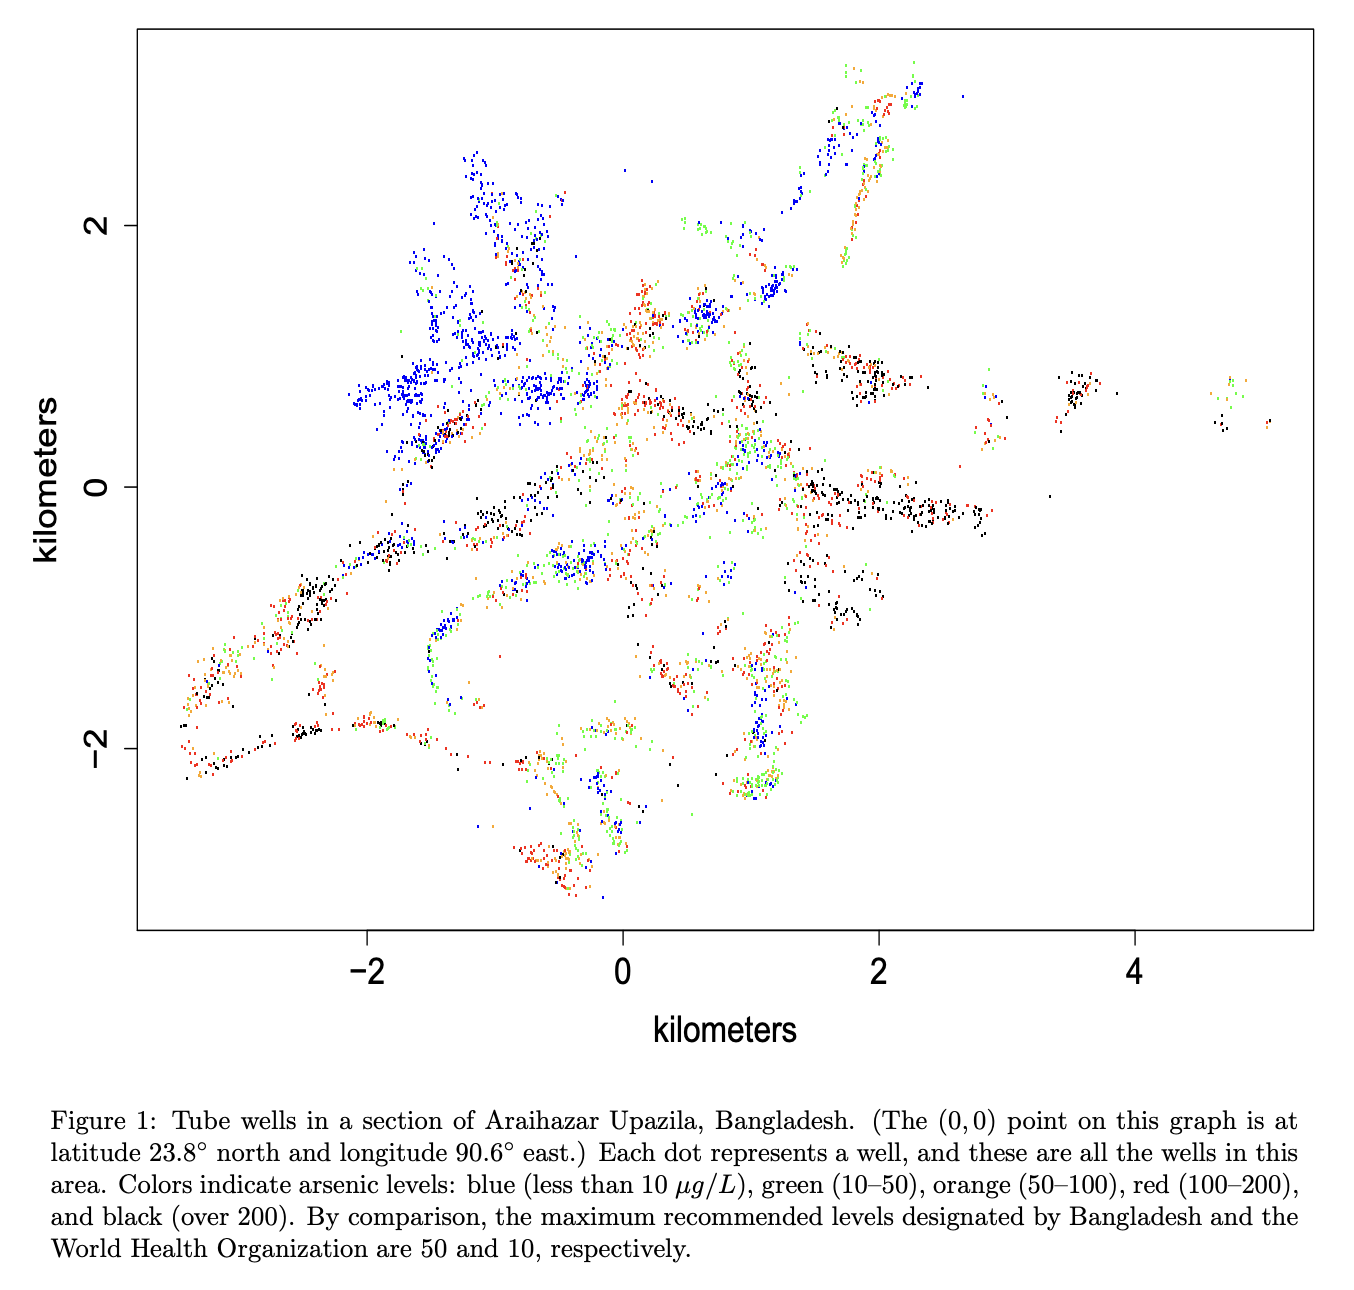

---

## Load packages

In [ ]:
!pip install bambi

In [ ]:
from datetime import datetime
from math import exp
import random

import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import pymc as pm
import bambi as bmb
import arviz as az

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

In [ ]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

## List pre-defined style sheets provided by matplotlib:

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-doc',
 'arviz-docgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Visualization in Bayesian workflow
- ### Plot data
- ### Plot model
- ### Plot prior parameter distributions
- ### Plot prior predictive distributions
- ### Plot MCMC diagnostics
- ### Plot posterior parameter distributions
- ### Plot posterior predictive distributions
- ### Plot model comparisons

## Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository](https://github.com/avehtari/ROS-Examples/tree/master). For this example, we're working with the `wells` dataset from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html).

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
wells = pd.read_csv('https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Arsenic/data/wells.csv')
wells.round(1)

switch  arsenic  dist  dist100  assoc  educ  educ4
0          1      2.4  16.8      0.2      0     0    0.0
1          1      0.7  47.3      0.5      0     0    0.0
2          0      2.1  21.0      0.2      0    10    2.5
3          1      1.2  21.5      0.2      0    12    3.0
4          1      1.1  40.9      0.4      1    14    3.5
...      ...      ...   ...      ...    ...   ...    ...
3015       0      0.5  19.3      0.2      1     5    1.2
3016       0      1.1  21.4      0.2      1     3    0.8
3017       0      0.5   7.7      0.1      0     4    1.0
3018       0      0.6  22.8      0.2      0     3    0.8
3019       1      0.7  20.8      0.2      1     5    1.2

[3020 rows x 7 columns]

## Explore Data

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
wells.isna().sum()

switch     0
arsenic    0
dist       0
dist100    0
assoc      0
educ       0
educ4      0
dtype: int64

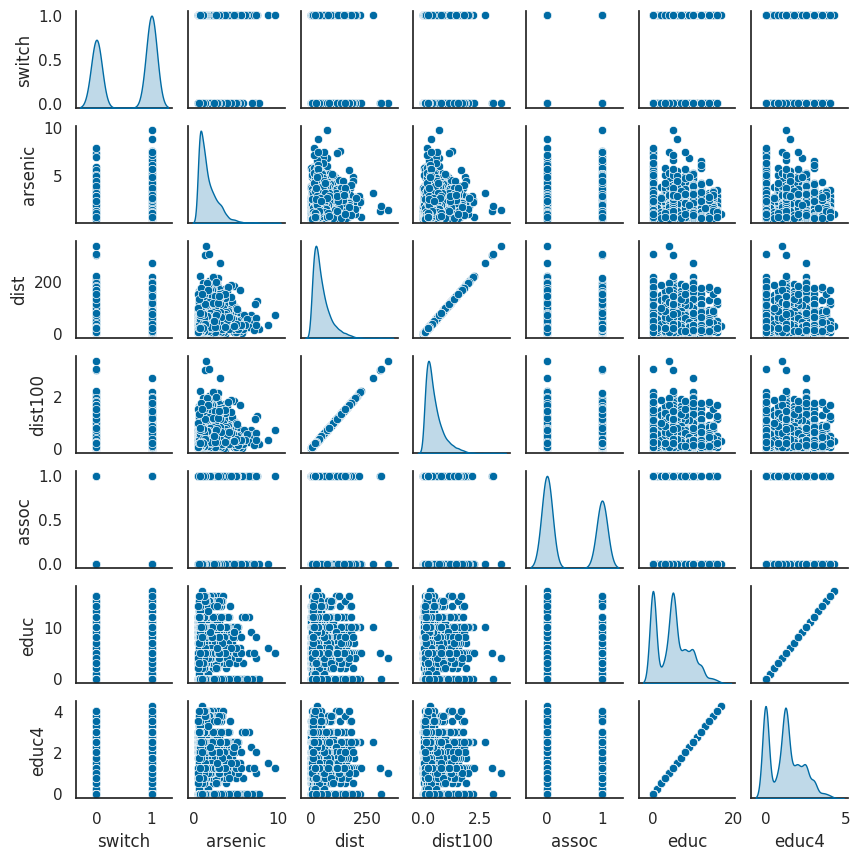

In [ ]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(wells, diag_kind='kde', height=1.25, aspect=1);

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
wells.describe().round(decimals=1)  # transpose().round(decimals=1)

switch  arsenic    dist  dist100   assoc    educ   educ4
count  3020.0   3020.0  3020.0   3020.0  3020.0  3020.0  3020.0
mean      0.6      1.7    48.3      0.5     0.4     4.8     1.2
std       0.5      1.1    38.5      0.4     0.5     4.0     1.0
min       0.0      0.5     0.4      0.0     0.0     0.0     0.0
25%       0.0      0.8    21.1      0.2     0.0     0.0     0.0
50%       1.0      1.3    36.8      0.4     0.0     5.0     1.2
75%       1.0      2.2    64.0      0.6     1.0     8.0     2.0
max       1.0      9.6   339.5      3.4     1.0    17.0     4.2

In [ ]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
statsmodels.stats.descriptivestats.describe(wells).round(2)

switch  arsenic     dist  dist100    assoc     educ  \
nobs              3020.00  3020.00  3020.00  3020.00  3020.00  3020.00   
missing              0.00     0.00     0.00     0.00     0.00     0.00   
mean                 0.58     1.66    48.33     0.48     0.42     4.83   
std_err              0.01     0.02     0.70     0.01     0.01     0.07   
upper_ci             0.59     1.70    49.70     0.50     0.44     4.97   
lower_ci             0.56     1.62    46.96     0.47     0.41     4.69   
std                  0.49     1.11    38.48     0.38     0.49     4.02   
iqr                  1.00     1.38    42.92     0.43     1.00     8.00   
iqr_normal           0.74     1.02    31.82     0.32     0.74     5.93   
mad                  0.49     0.85    28.89     0.29     0.49     3.20   
mad_normal           0.61     1.07    36.21     0.36     0.61     4.01   
coef_var             0.86     0.67     0.80     0.80     1.17     0.83   
range                1.00     9.14   339.14     3.39     1.00    17.00   
max                  1.00     9.65   339.53     3.40     1.00    17.00   
min                  0.00     0.51     0.39     0.00     0.00     0.00   
skew                -0.30     1.66     1.70     1.70     0.31     0.41   
kurtosis             1.09     6.96     7.26     7.26     1.10     2.40   
jarque_bera        504.41  3357.00  3741.66  3741.66   504.53   129.89   
jarque_bera_pval     0.00     0.00     0.00     0.00     0.00     0.00   
mode                 1.00     0.52   107.69     1.08     0.00     0.00   
mode_freq            0.58     0.01     0.00     0.00     0.58     0.29   
median               1.00     1.30    36.76     0.37     0.00     5.00   
1%                   0.00     0.52     3.50     0.04     0.00     0.00   
5%                   0.00     0.56     7.99     0.08     0.00     0.00   
10%                  0.00     0.62    11.58     0.12     0.00     0.00   
25%                  0.00     0.82    21.12     0.21     0.00     0.00   
50%                  1.00     1.30    36.76     0.37     0.00     5.00   
75%                  1.00     2.20    64.04     0.64     1.00     8.00   
90%                  1.00     3.21   100.74     1.01     1.00    10.00   
95%                  1.00     3.79   128.10     1.28     1.00    12.00   
99%                  1.00     5.25   175.50     1.75     1.00    15.00   

                    educ4  
nobs              3020.00  
missing              0.00  
mean                 1.21  
std_err              0.02  
upper_ci             1.24  
lower_ci             1.17  
std                  1.00  
iqr                  2.00  
iqr_normal           1.48  
mad                  0.80  
mad_normal           1.00  
coef_var             0.83  
range                4.25  
max                  4.25  
min                  0.00  
skew                 0.41  
kurtosis             2.40  
jarque_bera        129.89  
jarque_bera_pval     0.00  
mode                 0.00  
mode_freq            0.29  
median               1.25  
1%                   0.00  
5%                   0.00  
10%                  0.00  
25%                  0.00  
50%                  1.25  
75%                  2.00  
90%                  2.50  
95%                  3.00  
99%                  3.75

---

# 1. An intercept (a column of 1s)

## Estimating a proportion is the same as regressing on a constant term

## Plot data

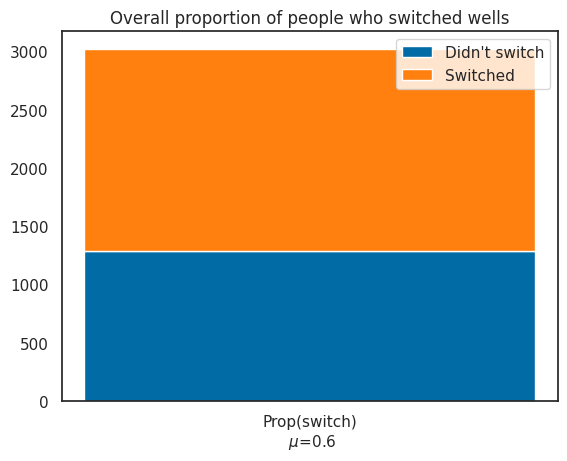

In [ ]:
# @title
n_switched = len(wells.loc[wells.switch == 1, :])
n_didnt_switch = len(wells.loc[wells.switch == 0, :])

p_switched = (
    "Prop(switch)\n $\mu$={}".format(np.round(n_switched / (n_switched+n_didnt_switch), decimals=1)),
)

weight_counts = {
    "Didn't switch": np.array([n_didnt_switch]),
    "Switched": np.array([n_switched]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(1)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(p_switched, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count


ax.set_title("Overall proportion of people who switched wells")
ax.legend(loc="upper right");

In [ ]:
# Mean of switch (overall proportion of people who switched wells)
wells.switch.mean().round(1)

0.6

In [ ]:
# Standard deviation of switch
wells.switch.std().round(1)

0.5

## Plot model

Produce a [graph](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.graph)viz Digraph from a built Bambi model.

The graph shows that, in the model, `switch` is distributed as a [Bernoulli distribution](https://distribution-explorer.github.io/discrete/bernoulli.html), with a mean (`Intercept`) that is distributed as a normal, [Gaussian distribution](https://distribution-explorer.github.io/continuous/normal.html).

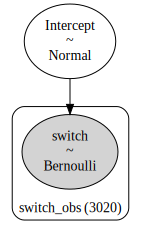

In [ ]:
m1 = bmb.Model('switch ~ 1', data=wells, family="bernoulli")

m1.build()

m1.graph()

In [ ]:
m1

       Formula: switch ~ 1
        Family: bernoulli
          Link: p = logit
  Observations: 3020
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)

---

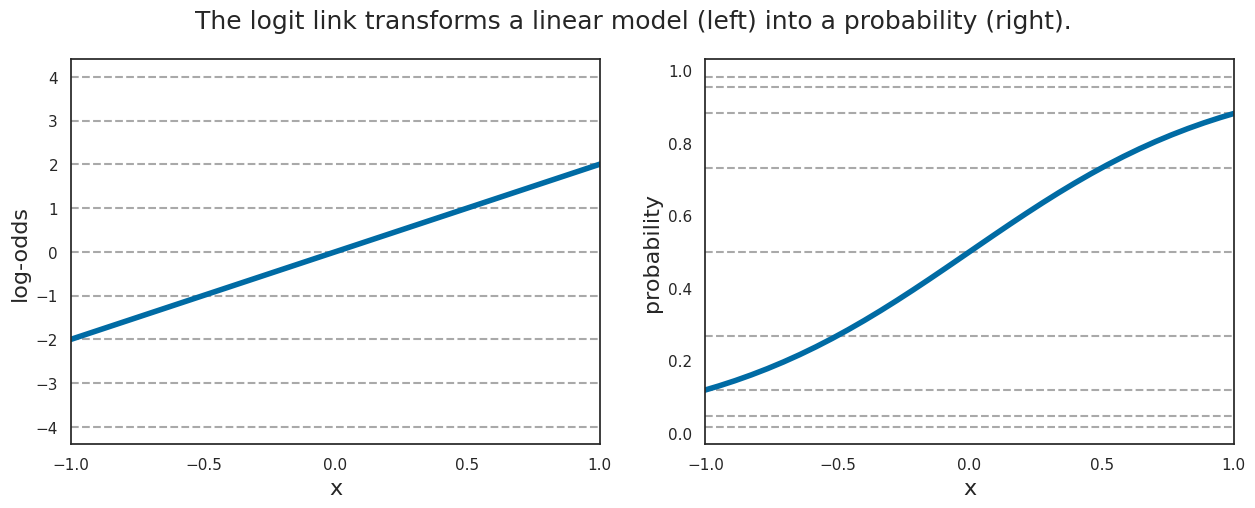

In [ ]:
# @title
# SOURCE: https://bookdown.org/content/4857/big-entropy-and-the-generalized-linear-model.html#linking-linear-models-to-distributions.
# Statistical Rethinking, 2nd Ed Figure 10.7 Page 317

# data for the horizontal lines
alpha = 0
beta  = 4
x = pd.Series(np.arange(-1, 1.25, .25))
log_odds = pd.Series(alpha + x * beta)
probability = pd.Series([exp(lo) / (1 + exp(lo)) for lo in log_odds])  # alternatively:  expit(lo)
lines = pd.concat([x, log_odds, probability], axis=1)
lines.columns = ['x', 'log_odds', 'probability']

# primary data
beta = 2
x = pd.Series(np.linspace(-1.5, 1.5, 50))
log_odds = pd.Series(alpha + x * beta)
probability = pd.Series([exp(lo) / (1 + exp(lo)) for lo in log_odds])
d = pd.concat([x, log_odds, probability], axis=1)
d.columns = ['x', 'log_odds', 'probability']

# plot log_odds and probability
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

[ax[0].axhline(y=i, linestyle='--', color='darkgray') for i in lines['log_odds']]
ax[0].plot('x', 'log_odds', lw=4, data=d)
ax[0].set_xlim(-1, 1)
ax[0].set_xticks(np.arange(-1, 1.5, .5))
ax[0].set_xlabel('x', fontsize=16)
ax[0].set_ylabel('log-odds', fontsize=16)

[ax[1].axhline(y=i, linestyle='--', color='darkgray') for i in lines['probability']]
ax[1].plot('x', 'probability', lw=4, data=d)
ax[1].set_xlim(-1, 1)
ax[1].set_xticks(np.arange(-1, 1.5, .5))
ax[1].set_xlabel('x', fontsize=16)
ax[1].set_ylabel('probability', fontsize=16)

plt.suptitle('The logit link transforms a linear model (left) into a probability (right).', fontsize=18);

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

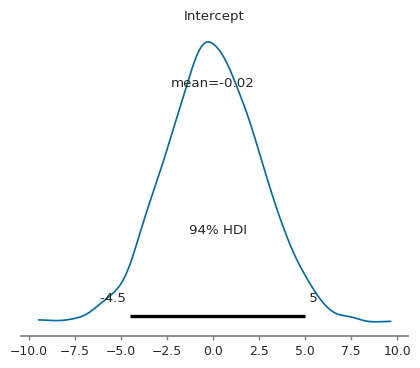

In [ ]:
m1.plot_priors(figsize=(5,4));

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m1_fit = m1.fit(idata_kwargs=dict(log_likelihood=True))

m1_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

[Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

In [ ]:
# Rename parameters
# Assign to new variable because renaming interferes with later step:
# posterior_predictive = m1.predict(m1_fit, kind="pps")
m1_fit_renamed = m1_fit.rename_vars({"Intercept": "mu"})
m1_fit_renamed

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

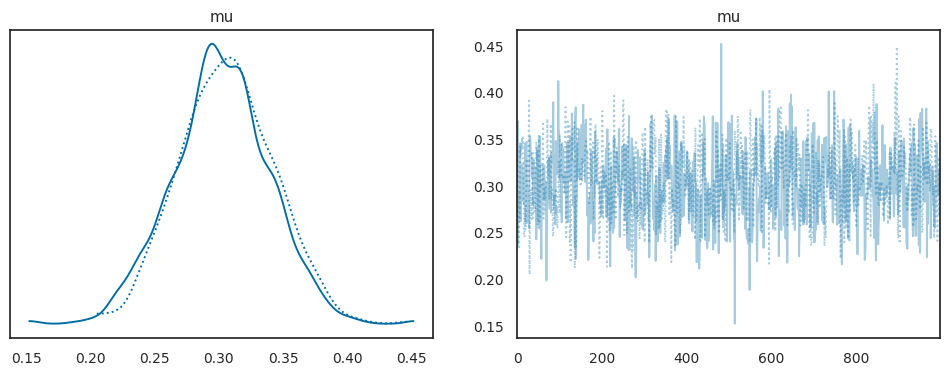

In [ ]:
az.plot_trace(m1_fit_renamed, figsize=(12,4));

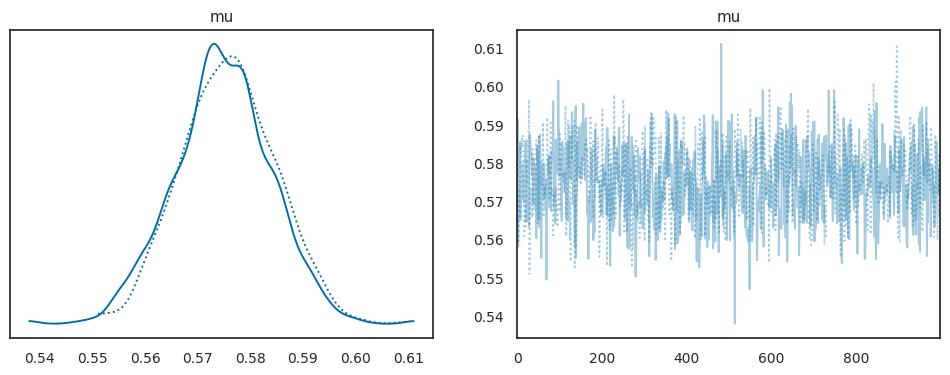

In [ ]:
# Inverse-logit function: expit(m1_fit_renamed.posterior["mu"])

az.plot_trace(expit(m1_fit_renamed.posterior["mu"]), figsize=(12,4));

## Plot posterior distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

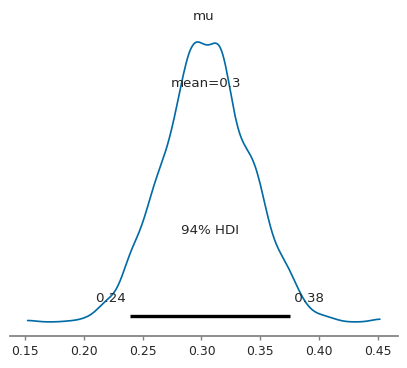

In [ ]:
az.plot_posterior(m1_fit_renamed, figsize=(5,4));

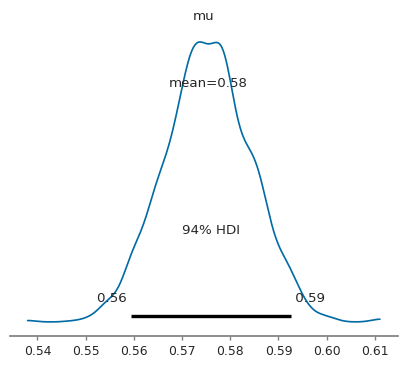

In [ ]:
# Inverse-logit function: expit(m1_fit_renamed.posterior["mu"])

az.plot_posterior(expit(m1_fit_renamed.posterior["mu"]), figsize=(5,4));

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [ ]:
az.summary(m1_fit_renamed).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
mu   0.3  0.04    0.24     0.38        0.0      0.0     865.0    1162.0   1.01

In [ ]:
# Inverse-logit function: expit(m1_fit_renamed.posterior["mu"])

az.summary(expit(m1_fit_renamed.posterior["mu"])).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
mu  0.57  0.01    0.56     0.59        0.0      0.0     865.0    1162.0   1.01

In [ ]:
# m1_df = az.extract_dataset(m1_fit).to_dataframe() # [['Intercept', 'kid_score_sigma']]

m1_df = az.extract_dataset(m1_fit_renamed).to_dataframe()[['mu']]
m1_df.round(2)

mu
chain draw      
0     0     0.24
      1     0.37
      2     0.24
      3     0.28
      4     0.26
...          ...
1     995   0.29
      996   0.33
      997   0.27
      998   0.29
      999   0.32

[2000 rows x 1 columns]

In [ ]:
m1_df.describe().T.round(2)

count  mean   std   min   25%  50%   75%   max
mu  2000.0   0.3  0.04  0.15  0.28  0.3  0.33  0.45

In [ ]:
# Inverse-logit function: expit()

m1_df.mu.map(expit).describe().round(2)

count    2000.00
mean        0.58
std         0.01
min         0.54
25%         0.57
50%         0.58
75%         0.58
max         0.61
Name: mu, dtype: float64

In [ ]:
# m1_fit.posterior["Intercept"][0][:10] # .to_pandas() or .to_series()

m1_fit_renamed.posterior["mu"][0][:10] # .to_pandas() or .to_series()

<xarray.DataArray 'mu' (draw: 10)>
array([0.23658407, 0.36925009, 0.23669005, 0.28067503, 0.26258035,
       0.34320294, 0.26280663, 0.34537301, 0.26164663, 0.28345685])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

## Plot posterior predictive distributions

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"mean"` or `"pps"`. The first returns draws from the posterior distribution of the mean, while the latter returns the draws from the posterior predictive distribution. Defaults to "mean".

If `kind="mean"`, a new variable ending in `"_mean"` is added to the `posterior` group. If `kind="pps"`, it appends a `posterior_predictive` group to `idata`. If any of these already exist, it will be overwritten.

In [ ]:
posterior_predictive = m1.predict(m1_fit, kind="pps")
m1_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

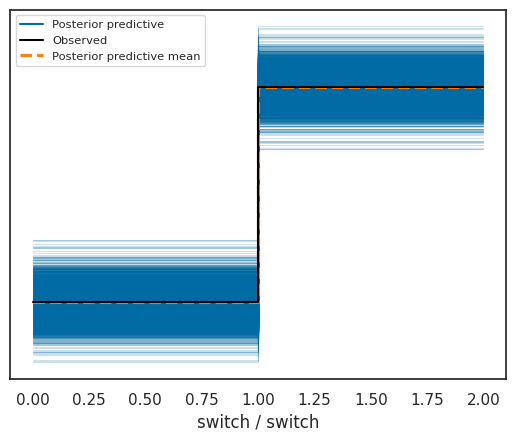

In [ ]:
az.plot_ppc(m1_fit);

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [ ]:
loo1 = az.loo(m1_fit)
loo1

Computed from 2000 posterior samples and 3020 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2060.05     8.25
p_loo        1.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

# An index variable (or a binary indicator)

### Estimating a difference in proportions is the same as regressing on an indicator variable (Z test)

## Summarize variables

In [ ]:
wells.arsenic.median().round(2)

1.3

In [ ]:
# Rescale distance into 100-meter units
wells['dist100'] = wells.dist / 100.0

# Jittered version of switch for plots
wells['switch_jitter'] = wells.switch.apply(lambda val: (val + np.random.uniform(low=0, high=0.1)) if val == 0 else (val - np.random.uniform(low=0, high=0.1)))

# Create binary variable
wells['arsenic_high'] = np.where(wells.arsenic >= wells.arsenic.median(), 1, 0)
wells

switch  arsenic       dist  dist100  assoc  educ  educ4  switch_jitter  \
0          1     2.36  16.826000  0.16826      0     0   0.00       0.904885   
1          1     0.71  47.321999  0.47322      0     0   0.00       0.943946   
2          0     2.07  20.966999  0.20967      0    10   2.50       0.054694   
3          1     1.15  21.486000  0.21486      0    12   3.00       0.912987   
4          1     1.10  40.874001  0.40874      1    14   3.50       0.997393   
...      ...      ...        ...      ...    ...   ...    ...            ...   
3015       0     0.52  19.347000  0.19347      1     5   1.25       0.049827   
3016       0     1.08  21.386000  0.21386      1     3   0.75       0.098028   
3017       0     0.51   7.708000  0.07708      0     4   1.00       0.018446   
3018       0     0.64  22.841999  0.22842      0     3   0.75       0.090750   
3019       1     0.66  20.844000  0.20844      1     5   1.25       0.931050   

      arsenic_high  
0                1  
1                0  
2                1  
3                0  
4                0  
...            ...  
3015             0  
3016             0  
3017             0  
3018             0  
3019             0  

[3020 rows x 9 columns]

In [ ]:
wells.groupby('arsenic_high')['switch'].describe().round(1)

count  mean  std  min  25%  50%  75%  max
arsenic_high                                            
0             1508.0   0.5  0.5  0.0  0.0  0.0  1.0  1.0
1             1512.0   0.7  0.5  0.0  0.0  1.0  1.0  1.0

## Plot data

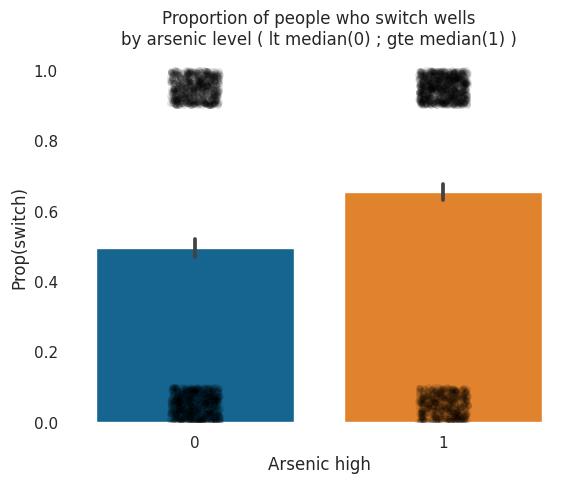

In [ ]:
sns.barplot(x='arsenic_high', y='switch', data=wells)
sns.stripplot(x='arsenic_high', y='switch_jitter', data=wells, color='black', alpha=0.1)
sns.despine(left=True, bottom=True)
plt.xlabel('Arsenic high')
plt.ylabel('Prop(switch)')
plt.title("Proportion of people who switch wells\nby arsenic level ( lt median(0) ; gte median(1) )");

In [ ]:
sns.set_style("whitegrid")

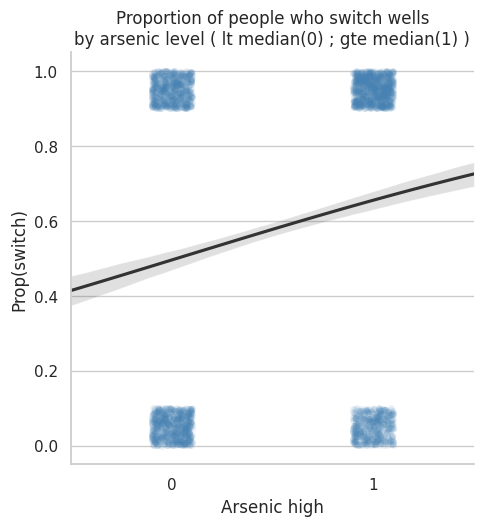

In [ ]:
sns.catplot(data=wells, x="arsenic_high", y="switch_jitter", color="steelblue", alpha=0.1, zorder=1)
sns.regplot(data=wells, x="arsenic_high", y="switch", logistic=True, scatter=False, truncate=False, color=".2")
#sns.despine(left=True, bottom=True)
plt.xlabel('Arsenic high')
plt.ylabel('Prop(switch)')
plt.title("Proportion of people who switch wells\nby arsenic level ( lt median(0) ; gte median(1) )");

## Plot model

In [ ]:
# wells['arsenic_high'] = wells.arsenic_high.astype('category')

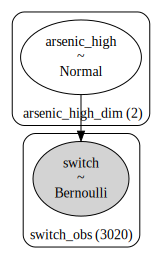

In [ ]:
m2 = bmb.Model('switch ~ 0 + arsenic_high', data=wells, family="bernoulli", categorical=['arsenic_high'])

m2.build()

m2.graph()

In [ ]:
m2

       Formula: switch ~ 0 + arsenic_high
        Family: bernoulli
          Link: p = logit
  Observations: 3020
        Priors: 
    target = p
        Common-level effects
            arsenic_high ~ Normal(mu: [0. 0.], sigma: [5. 5.])

## Plot prior parameter distributions

In [ ]:
az.style.use('arviz-darkgrid')

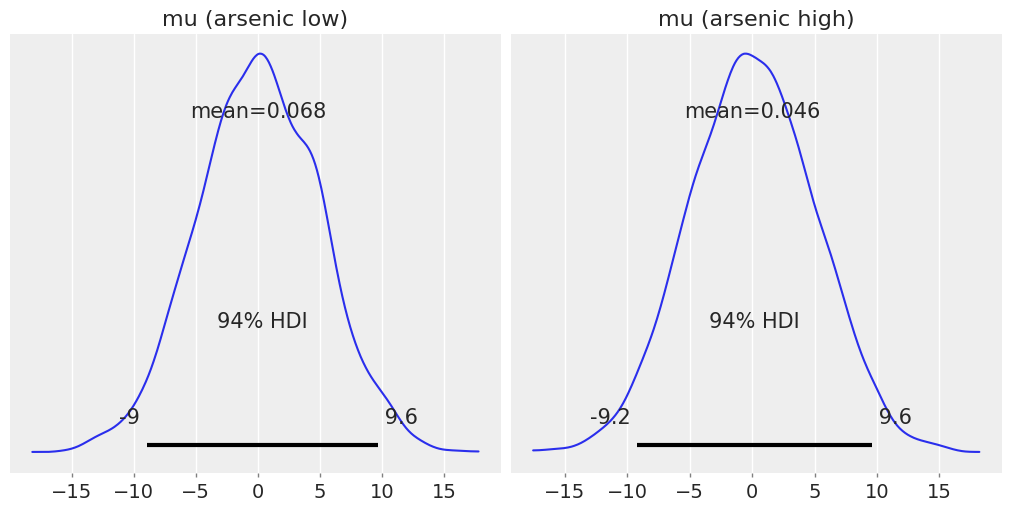

In [ ]:
axs = m2.plot_priors(figsize=(10,5))

titles = ['mu (arsenic low)', 'mu (arsenic high)']
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
plt.tight_layout();

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m2_fit = m2.fit(idata_kwargs=dict(log_likelihood=True))

m2_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
m2_fit_renamed = m2_fit.rename_vars({"arsenic_high": "logodds(switch)"})
m2_fit_renamed

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

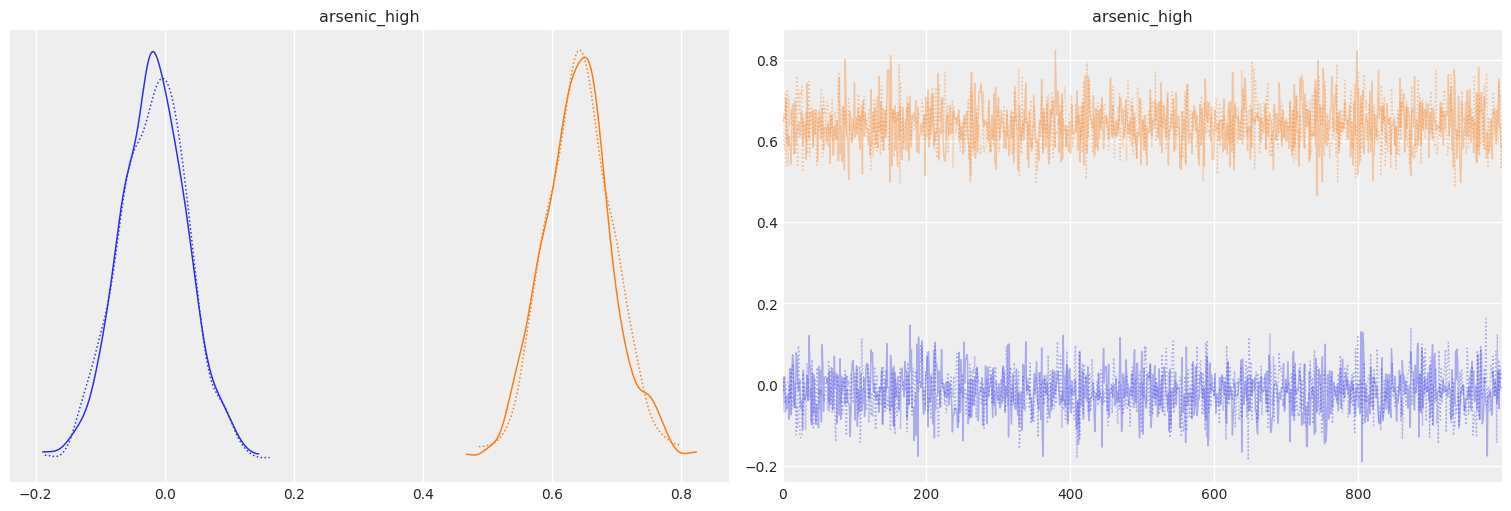

In [ ]:
az.plot_trace(m2_fit, figsize=(15,5));

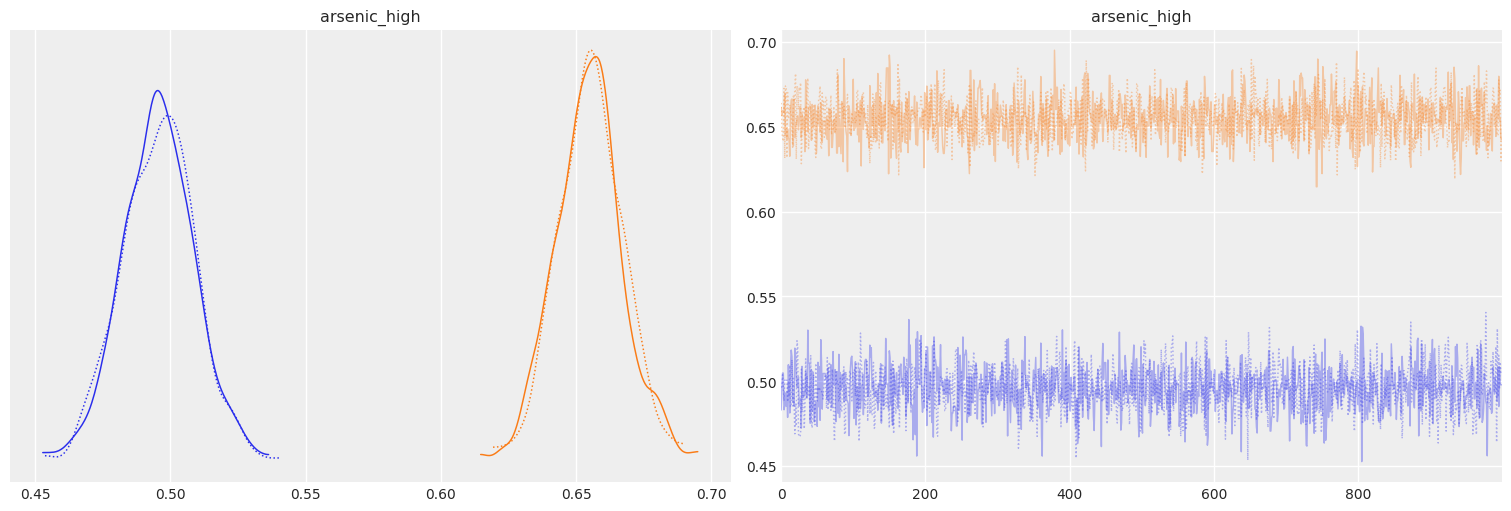

In [ ]:
# Inverse-logit function: expit()

az.plot_trace(expit(m2_fit.posterior["arsenic_high"]), figsize=(15,5));

## Plot posterior distributions

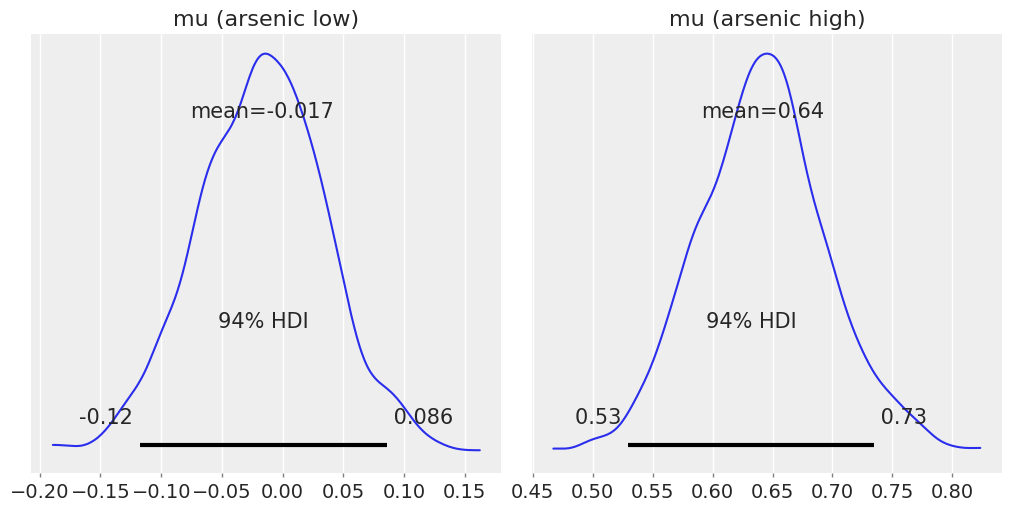

In [ ]:
axs = az.plot_posterior(m2_fit, figsize=(10,5))

titles = ['mu (arsenic low)', 'mu (arsenic high)']
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
plt.tight_layout();

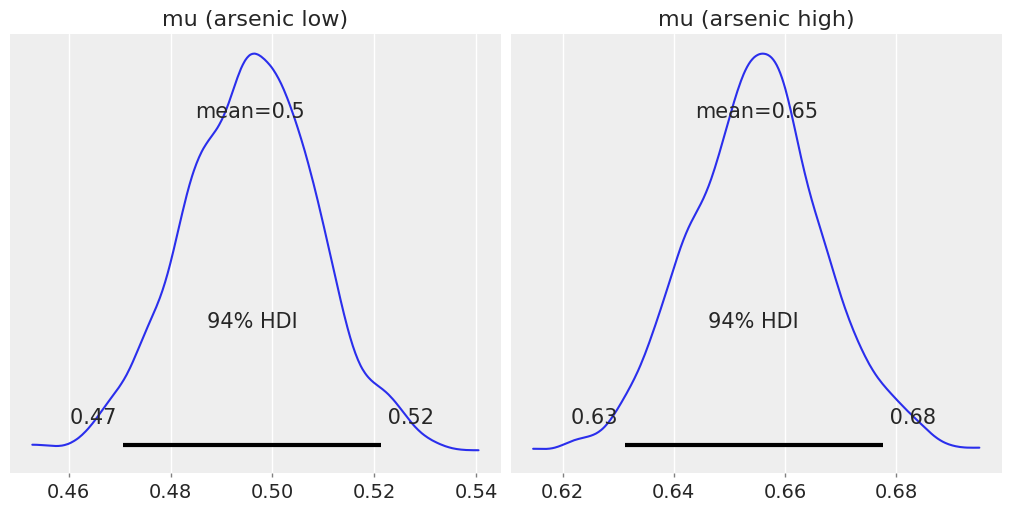

In [ ]:
# Inverse-logit function: expit()

axs = az.plot_posterior(expit(m2_fit_renamed.posterior["logodds(switch)"]), figsize=(10,5))

titles = ['mu (arsenic low)', 'mu (arsenic high)']
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
plt.tight_layout();

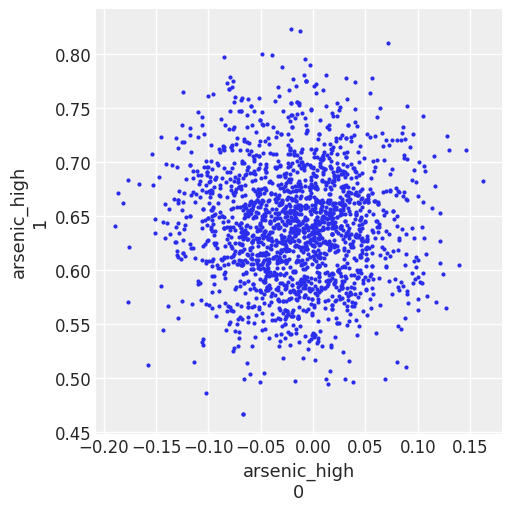

In [ ]:
az.plot_pair(m2_fit, figsize=(5,5));

In [ ]:
m2_df = az.extract_dataset(m2_fit_renamed).to_dataframe()[['logodds(switch)']].unstack(level=0)
m2_df

logodds(switch)          
arsenic_high_dim               0         1
chain draw                                
0     0                -0.067505  0.668955
      1                -0.016710  0.647958
      2                 0.019503  0.660047
      3                 0.019503  0.660047
      4                -0.066986  0.655413
...                          ...       ...
1     995               0.061062  0.742274
      996              -0.017999  0.706443
      997               0.045063  0.714904
      998               0.017197  0.531193
      999               0.014411  0.587329

[2000 rows x 2 columns]

In [ ]:
m2_df.describe().T.round(2)

count  mean   std   min   25%   50%   75%  \
                arsenic_high_dim                                               
logodds(switch) 0                 2000.0 -0.02  0.05 -0.19 -0.05 -0.02  0.02   
                1                 2000.0  0.64  0.05  0.47  0.61  0.64  0.67   

                                   max  
                arsenic_high_dim        
logodds(switch) 0                 0.16  
                1                 0.82

In [ ]:
# Inverse-logit function: expit()

m2_df_prob = m2_df.apply(expit).describe().T.round(2)
m2_df_prob.index = [val.replace('logodds(switch)', 'Pr(switch)') for val in m2_df_prob.index.get_level_values(0).to_list()]
m2_df_prob

count  mean   std   min   25%   50%   75%   max
Pr(switch)  2000.0  0.50  0.01  0.45  0.49  0.50  0.50  0.54
Pr(switch)  2000.0  0.65  0.01  0.61  0.65  0.66  0.66  0.70

## Interpret results

In [ ]:
# log odds
az.summary(m2_fit).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
arsenic_high[0] -0.02  0.05   -0.12     0.09        0.0      0.0    1976.0   
arsenic_high[1]  0.64  0.05    0.53     0.74        0.0      0.0    1907.0   

                 ess_tail  r_hat  
arsenic_high[0]    1433.0    1.0  
arsenic_high[1]    1361.0    1.0

In [ ]:
# probability
az.summary(m2_fit.map(expit)).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
arsenic_high[0]  0.50  0.01    0.47     0.52        0.0      0.0    1976.0   
arsenic_high[1]  0.66  0.01    0.63     0.68        0.0      0.0    1907.0   

                 ess_tail  r_hat  
arsenic_high[0]    1433.0    1.0  
arsenic_high[1]    1361.0    1.0

In [ ]:
m2_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

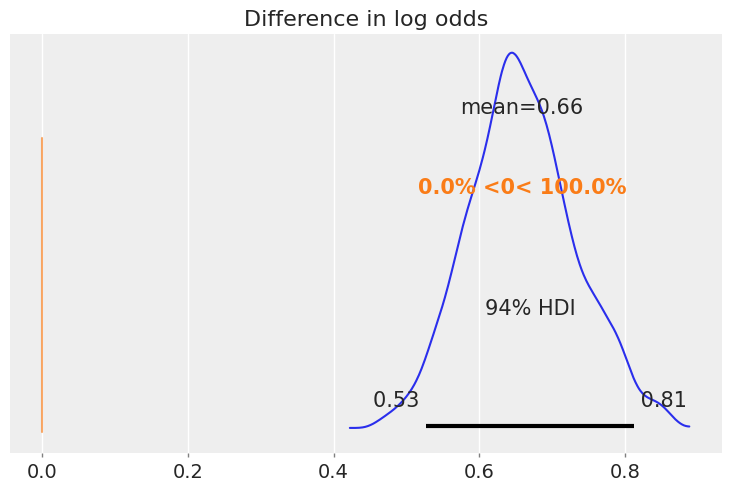

In [ ]:
post_mom_hs = m2_fit.posterior["arsenic_high"]

diff = post_mom_hs.sel(arsenic_high_dim="1") - post_mom_hs.sel(arsenic_high_dim="0")

az.plot_posterior(diff, ref_val=0)
plt.title('Difference in log odds');

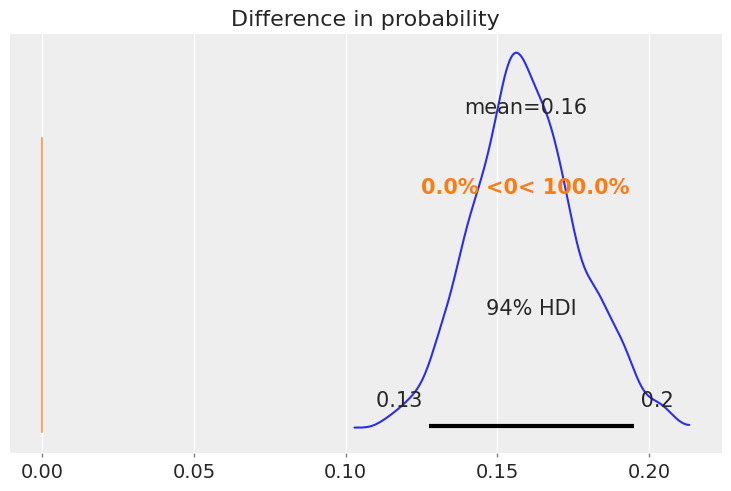

In [ ]:
post_mom_hs = m2_fit.map(expit).posterior["arsenic_high"]

diff = post_mom_hs.sel(arsenic_high_dim="1") - post_mom_hs.sel(arsenic_high_dim="0")

az.plot_posterior(diff, ref_val=0)
plt.title('Difference in probability');

In [ ]:
# Probabiliy that posterior is > 0
(post_mom_hs > 0).mean().item()

1.0

In [ ]:
posterior_predictive = m2.predict(m2_fit, kind="pps")
m2_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

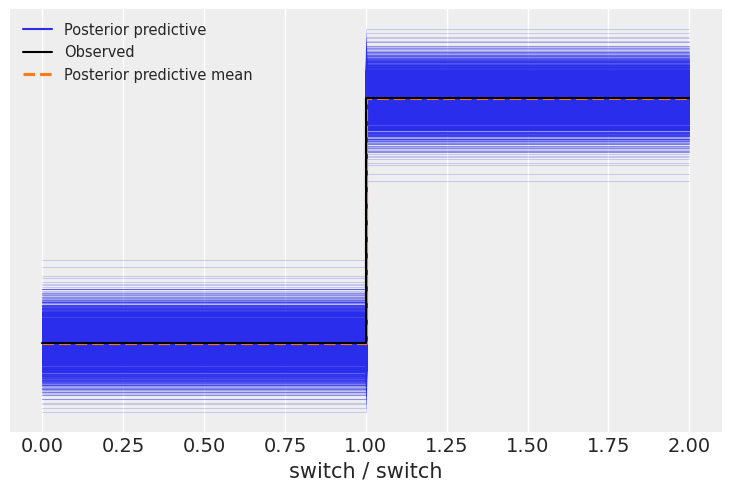

In [ ]:
az.plot_ppc(m2_fit);

In [ ]:
loo2 = az.loo(m2_fit)
loo2

Computed from 2000 posterior samples and 3020 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2021.65    11.95
p_loo        2.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Double-check with another [model](https://bambinos.github.io/bambi/notebooks/t-test.html#model-1)

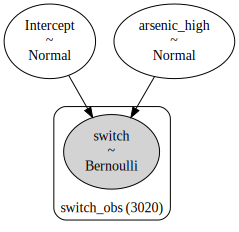

In [ ]:
m2b = bmb.Model('switch ~ 1 + arsenic_high', data=wells, family="bernoulli")

m2b.build()

m2b.graph()

In [ ]:
m2b

       Formula: switch ~ 1 + arsenic_high
        Family: bernoulli
          Link: p = logit
  Observations: 3020
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5379)
            arsenic_high ~ Normal(mu: 0.0, sigma: 5.0)

In [ ]:
m2b_fit = m2b.fit()
m2b_fit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
az.summary(m2b_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     -0.0  0.1    -0.1      0.1        0.0      0.0    1930.0   
arsenic_high   0.7  0.1     0.5      0.8        0.0      0.0    2073.0   

              ess_tail  r_hat  
Intercept       1305.0    1.0  
arsenic_high    1413.0    1.0

In [ ]:
posterior_predictive = m2b.predict(m2b_fit, kind="pps")
m2b_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [ ]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .05 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

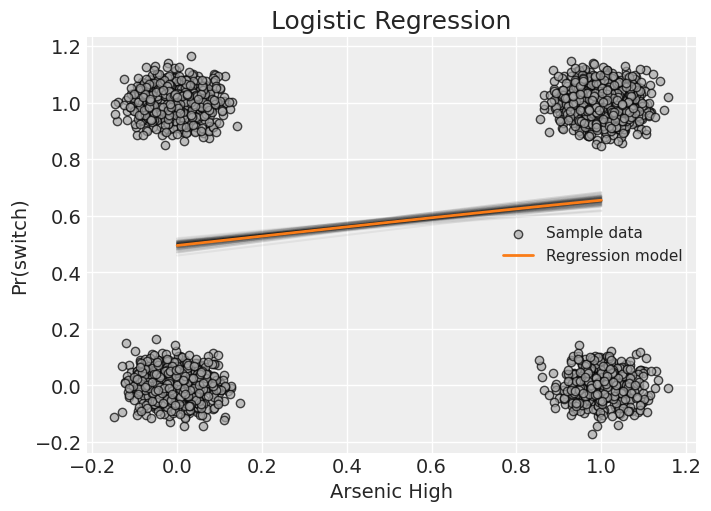

In [ ]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

x_axis = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
mu_pred = m2b_fit.posterior["Intercept"] + m2b_fit.posterior["arsenic_high"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(rand_jitter(wells.arsenic_high), rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, expit(mu_plot.isel(sample=random_subset)), color="black", alpha=0.05)
plt.plot(x_axis, expit(mu_mean), color="C1", lw=2.0, label='Regression model')

ax.set_xlabel('Arsenic High', fontsize=14)
ax.set_ylabel('Pr(switch)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

---

# A continuous variable

In [ ]:
sns.set_style("whitegrid")

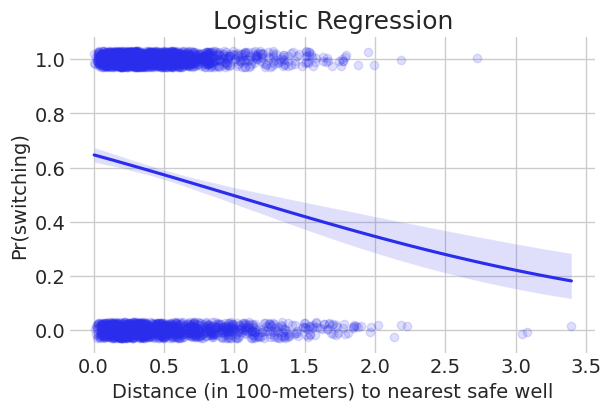

In [ ]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.regplot.html

fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(x="dist100", y="switch", data=wells,
            logistic=True, n_boot=500, y_jitter=.03,
            scatter_kws={'alpha': 0.15}, # Set transparency to 15%
            ax=ax)
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.set_title('Logistic Regression', fontsize=18);

## Plot model

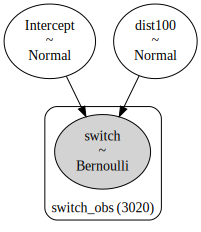

In [ ]:
m3 = bmb.Model('switch ~ 1 + dist100', data=wells, family="bernoulli")

m3.build()

m3.graph()

In [ ]:
m3

       Formula: switch ~ 1 + dist100
        Family: bernoulli
          Link: p = logit
  Observations: 3020
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.0142)
            dist100 ~ Normal(mu: 0.0, sigma: 6.4982)

## Plot prior parameter distributions

In [ ]:
az.style.use(['arviz-whitegrid', 'arviz-orangish'])

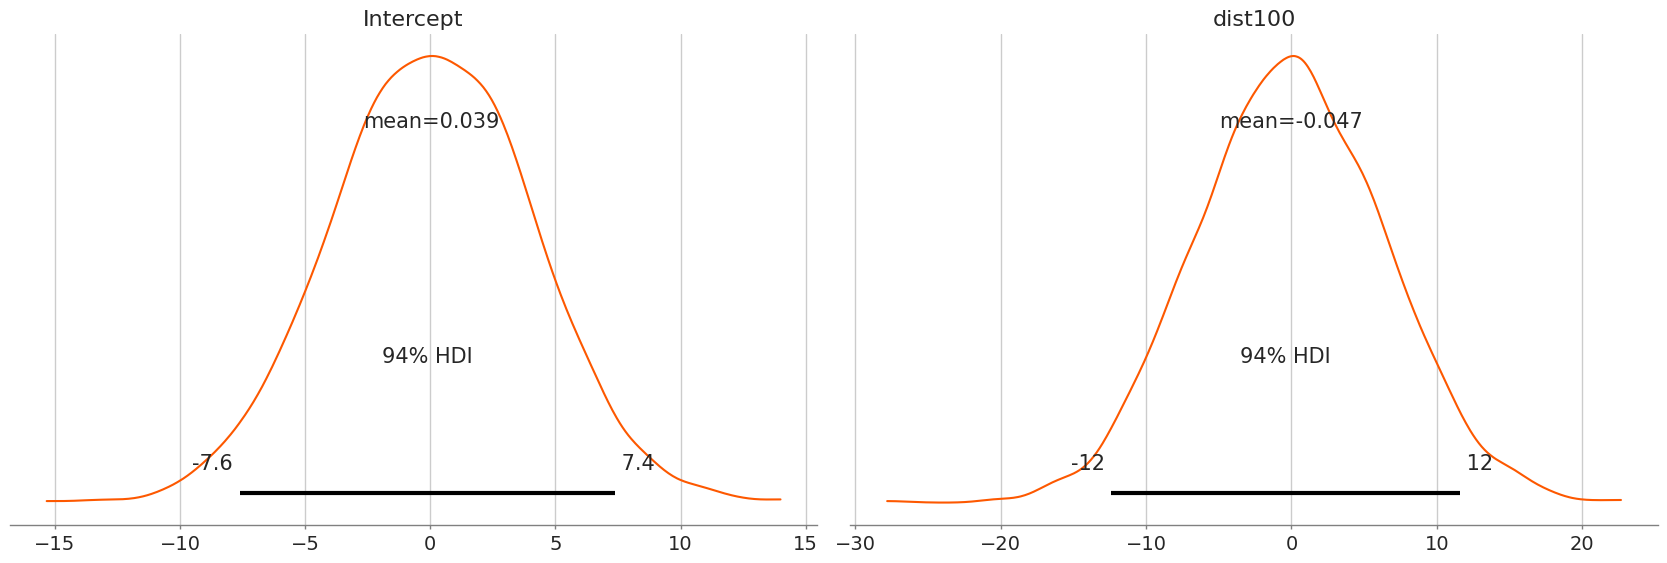

In [ ]:
m3.plot_priors();

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m3_fit = m3.fit(idata_kwargs=dict(log_likelihood=True))

m3_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

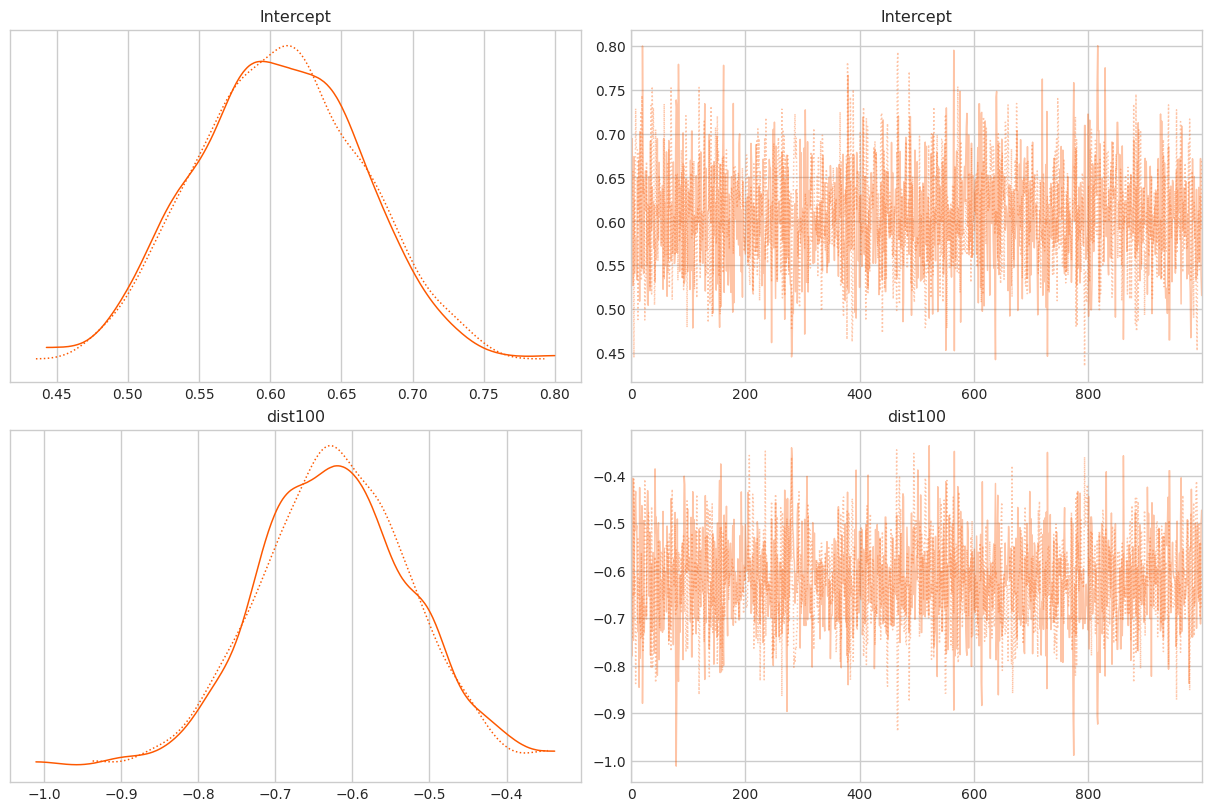

In [ ]:
az.plot_trace(m3_fit, figsize=(12,8));

## Plot posterior distributions

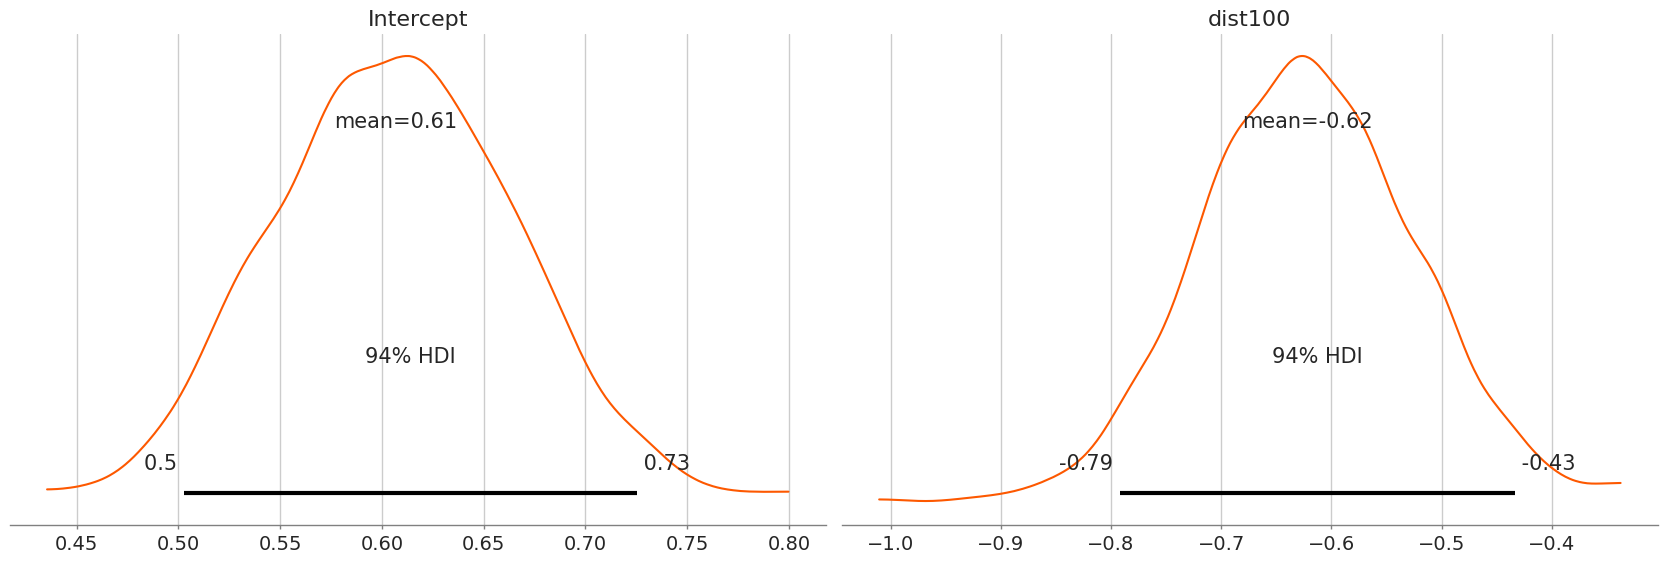

In [ ]:
az.plot_posterior(m3_fit);

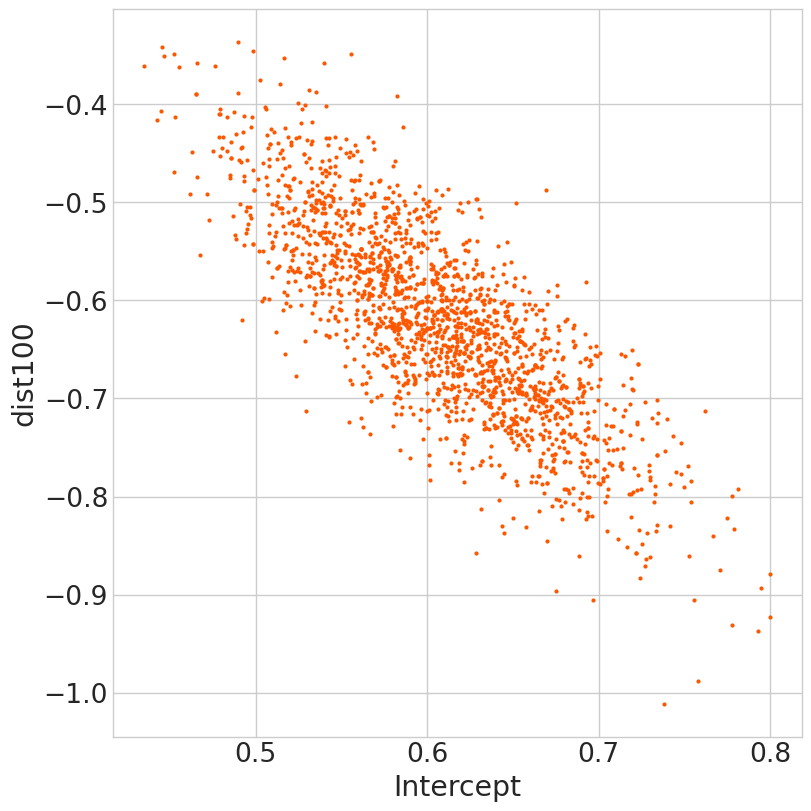

In [ ]:
az.plot_pair(m3_fit, figsize=(8,8));

In [ ]:
m3_df = az.extract_dataset(m3_fit).to_dataframe()[['Intercept', 'dist100']]
m3_df

Intercept   dist100
chain draw                     
0     0      0.639691 -0.589699
      1      0.531369 -0.552529
      2      0.694269 -0.779312
      3      0.527213 -0.405322
      4      0.621602 -0.746182
...               ...       ...
1     995    0.545043 -0.498783
      996    0.629096 -0.697931
      997    0.622548 -0.540239
      998    0.591882 -0.675848
      999    0.669890 -0.603463

[2000 rows x 2 columns]

In [ ]:
m3_df.describe().T.round(2)

count  mean   std   min   25%   50%   75%   max
Intercept  2000.0  0.61  0.06  0.44  0.57  0.61  0.65  0.80
dist100    2000.0 -0.62  0.10 -1.01 -0.69 -0.62 -0.56 -0.34

## Interpret results

In [ ]:
az.summary(m3_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept   0.6  0.1     0.5      0.7        0.0      0.0    1679.0    1461.0   
dist100    -0.6  0.1    -0.8     -0.4        0.0      0.0    1896.0    1452.0   

           r_hat  
Intercept    1.0  
dist100      1.0

In [ ]:
posterior_predictive = m3.predict(m3_fit, kind="pps")
m3_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

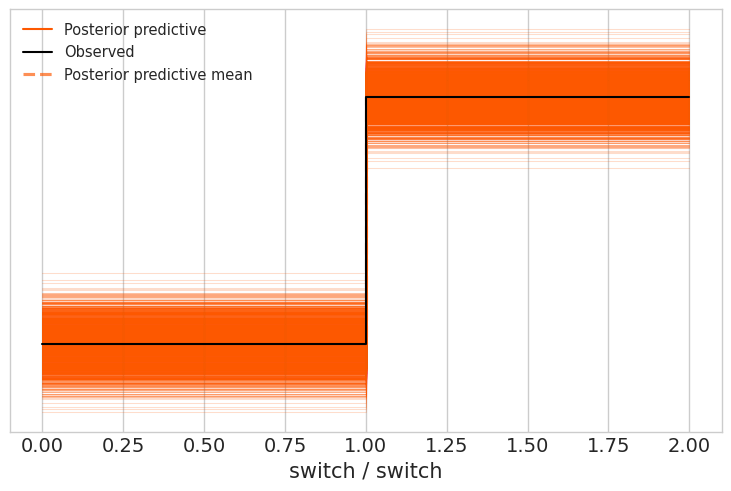

In [ ]:
az.plot_ppc(m3_fit);

In [ ]:
loo3 = az.loo(m3_fit)
loo3

Computed from 2000 posterior samples and 3020 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2040.05    10.42
p_loo        1.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

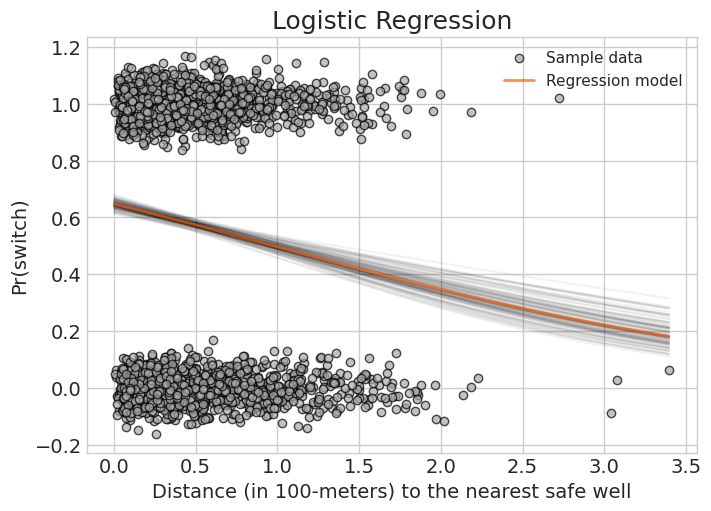

In [ ]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

x_axis = xr.DataArray(np.linspace(min(wells.dist100), max(wells.dist100), 2000), dims=["x_plot"])
mu_pred = m3_fit.posterior["Intercept"] + m3_fit.posterior["dist100"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, expit(mu_plot.isel(sample=random_subset)), color="black", alpha=0.05)
plt.plot(x_axis, expit(mu_mean), color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Pr(switch)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to the nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

---

## Two continuous predictors (no interaction)

In [ ]:
sns.set_theme()

In [ ]:
# Tableau 10 Blue and Orange
# https://jrnold.github.io/ggthemes/reference/tableau_color_pal.html

wells['dot_color'] = np.where(wells.arsenic_high == 0, "#4E79A7", "#F28E2B")

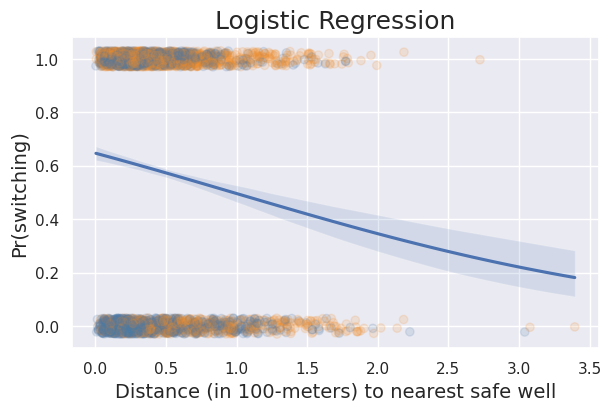

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(x="dist100", y="switch", data=wells,
            logistic=True, n_boot=500, y_jitter=.03,
            scatter_kws={'alpha': 0.15, 'color': list(wells['dot_color'].values)}, # Set transparency to 15%
            ax=ax)
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.set_title('Logistic Regression', fontsize=18);

## Plot model

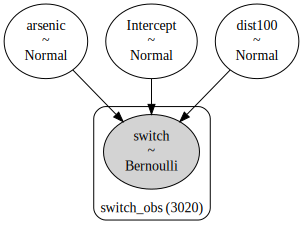

In [ ]:
m4 = bmb.Model('switch ~ 1 + arsenic + dist100', data=wells, family="bernoulli")

m4.build()

m4.graph()

In [ ]:
m4

       Formula: switch ~ 1 + arsenic + dist100
        Family: bernoulli
          Link: p = logit
  Observations: 3020
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.4873)
            arsenic ~ Normal(mu: 0.0, sigma: 2.2579)
            dist100 ~ Normal(mu: 0.0, sigma: 6.4982)

## Plot prior parameter distributions

In [ ]:
az.style.use(['arviz-white', 'arviz-purplish'])

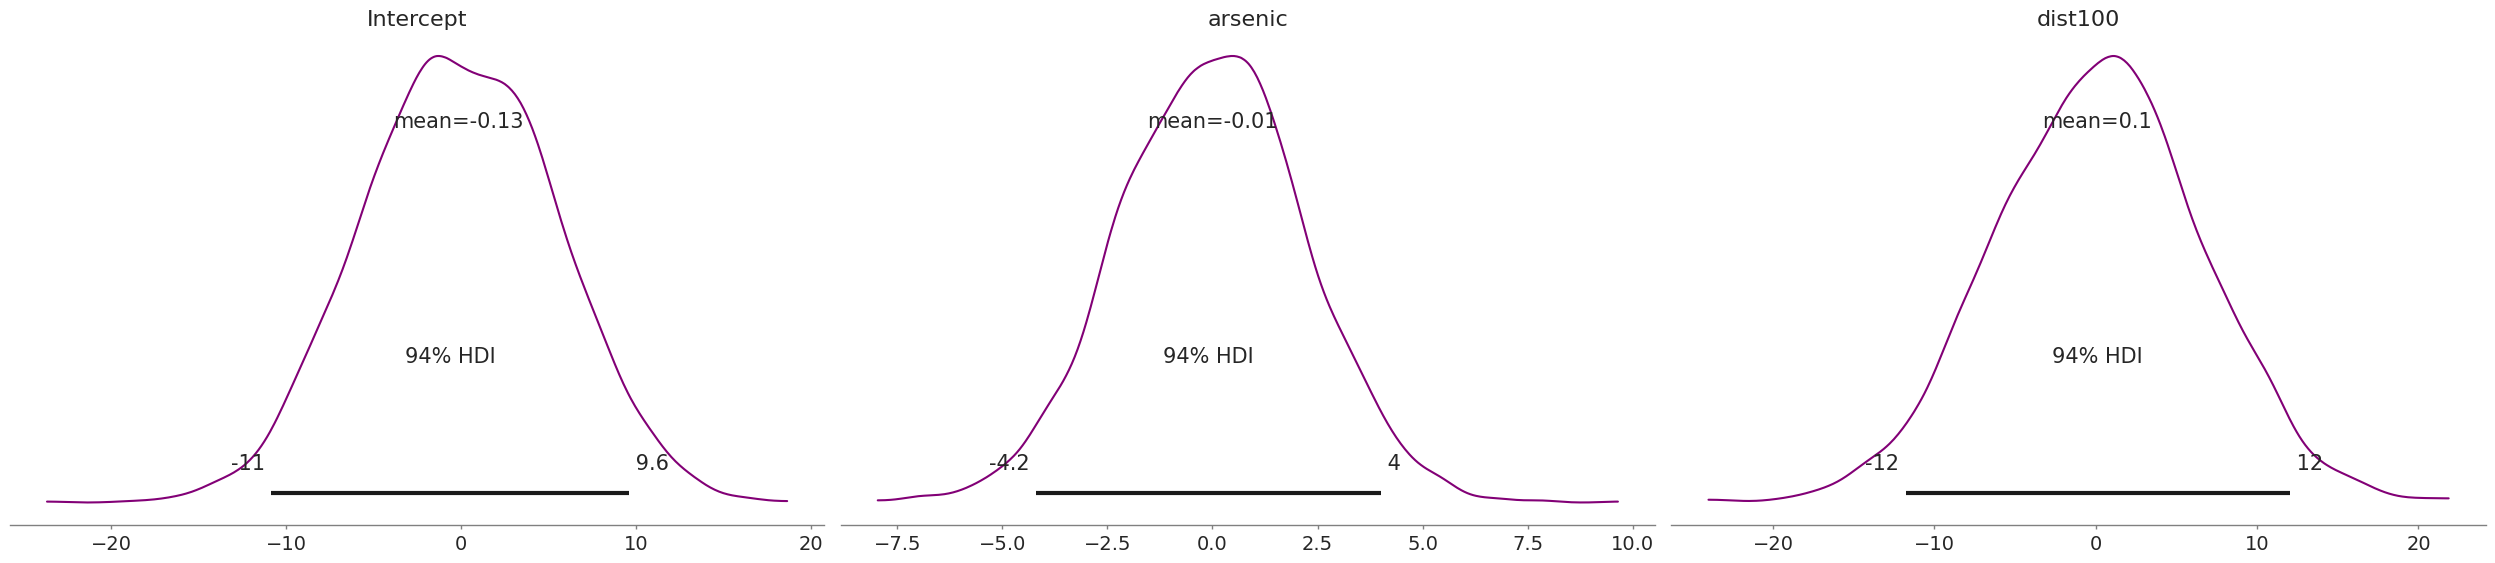

In [ ]:
m4.plot_priors();

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m4_fit = m4.fit(idata_kwargs=dict(log_likelihood=True))

m4_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

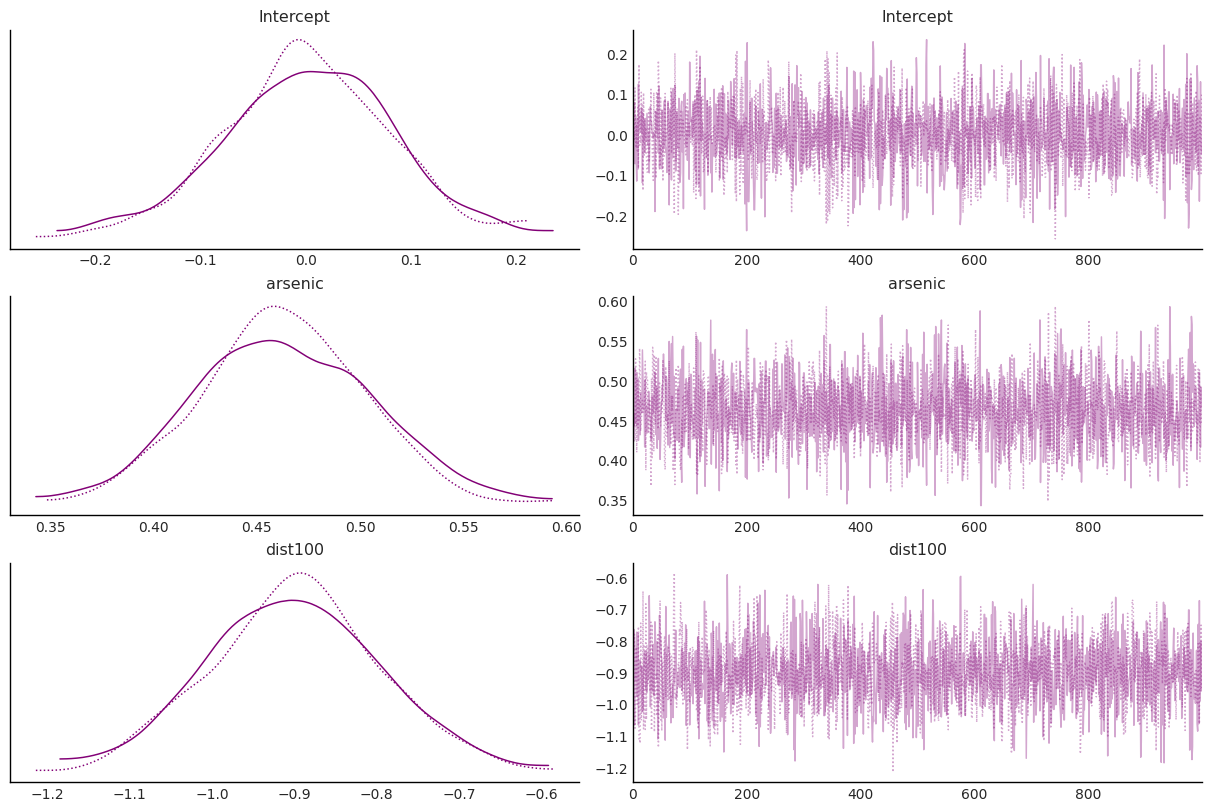

In [ ]:
az.plot_trace(m4_fit, figsize=(12,8));

## Plot posterior distributions

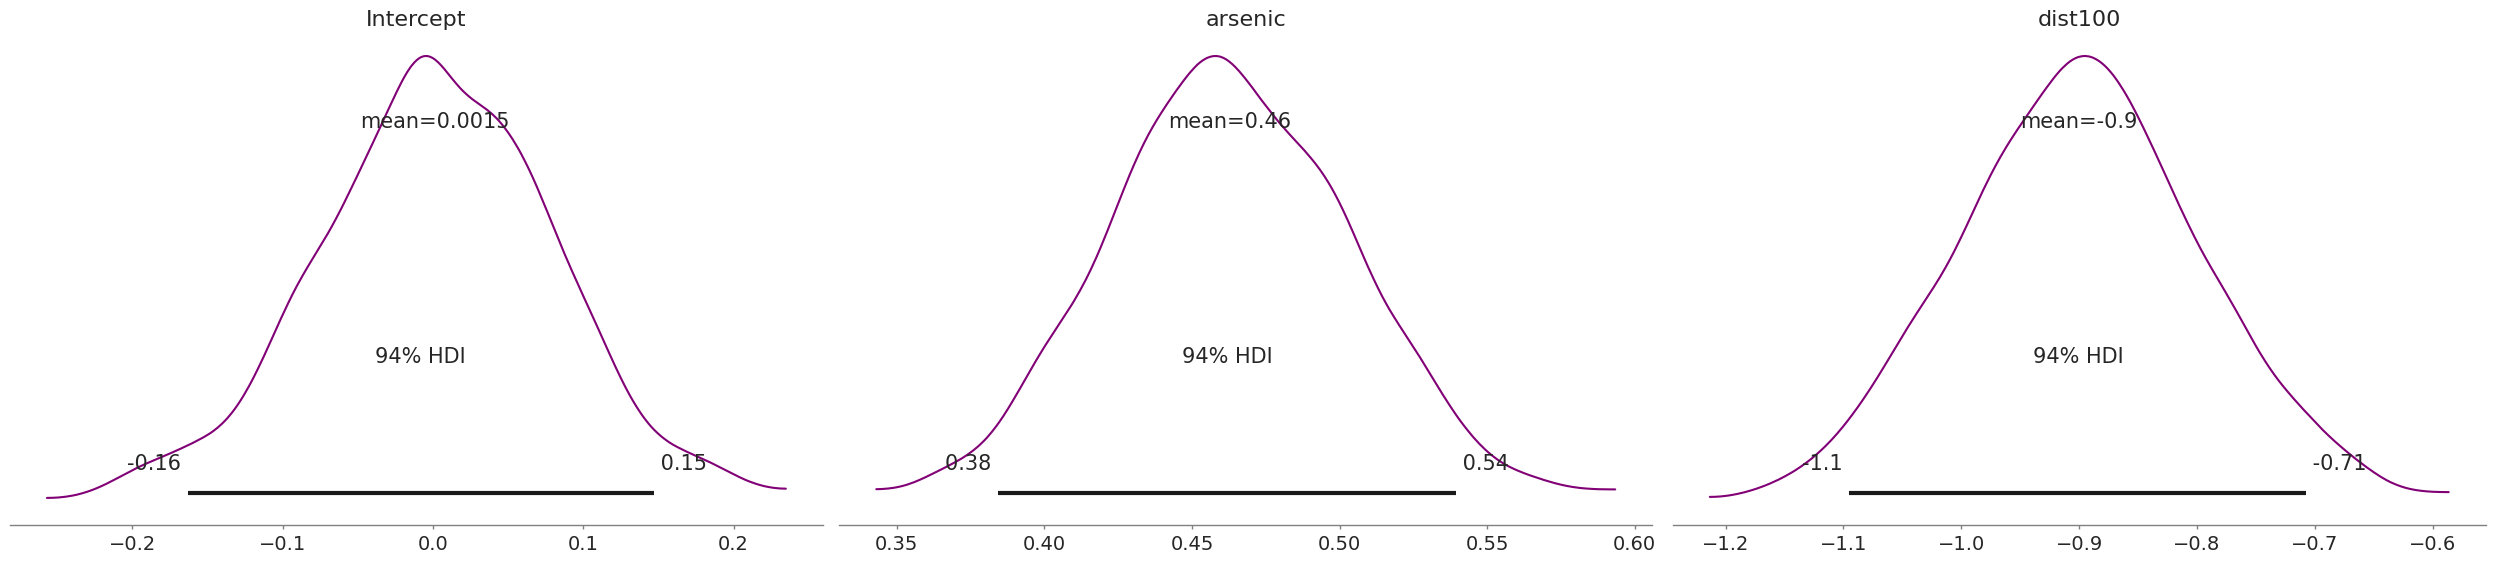

In [ ]:
az.plot_posterior(m4_fit);

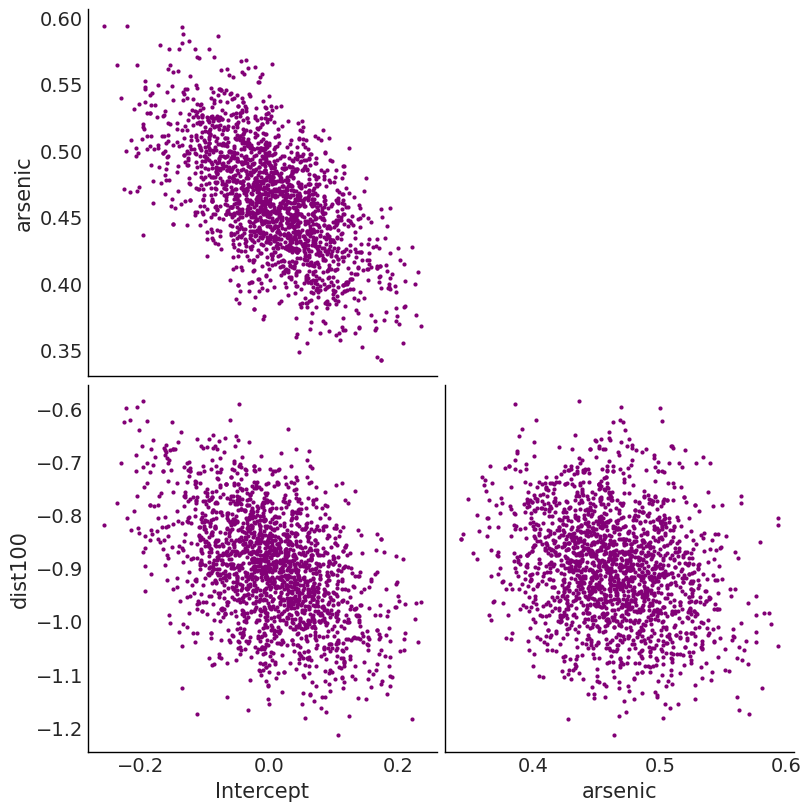

In [ ]:
az.plot_pair(m4_fit, figsize=(8,8));

In [ ]:
m4_df = az.extract_dataset(m4_fit).to_dataframe()[['Intercept', 'arsenic', 'dist100']]
m4_df

Intercept   arsenic   dist100
chain draw                               
0     0      0.074499  0.457206 -0.962223
      1      0.074499  0.457206 -0.962223
      2     -0.050397  0.442523 -0.763941
      3      0.079547  0.485254 -1.064518
      4     -0.071552  0.515480 -0.890513
...               ...       ...       ...
1     995   -0.010526  0.513485 -1.061193
      996    0.042087  0.398018 -0.806371
      997   -0.009386  0.494408 -0.959786
      998   -0.096013  0.455948 -0.750018
      999    0.103283  0.444574 -0.948269

[2000 rows x 3 columns]

In [ ]:
m4_df.describe().T.round(2)

count  mean   std   min   25%   50%   75%   max
Intercept  2000.0  0.00  0.08 -0.26 -0.05  0.00  0.06  0.24
arsenic    2000.0  0.46  0.04  0.34  0.43  0.46  0.49  0.59
dist100    2000.0 -0.90  0.10 -1.21 -0.97 -0.90 -0.83 -0.59

## Interpret results

In [ ]:
az.summary(m4_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept   0.0  0.1    -0.2      0.1        0.0      0.0    3024.0    1018.0   
arsenic     0.5  0.0     0.4      0.5        0.0      0.0    2898.0    1417.0   
dist100    -0.9  0.1    -1.1     -0.7        0.0      0.0    2689.0    1505.0   

           r_hat  
Intercept    1.0  
arsenic      1.0  
dist100      1.0

In [ ]:
posterior_predictive = m4.predict(m4_fit, kind="pps")
m4_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

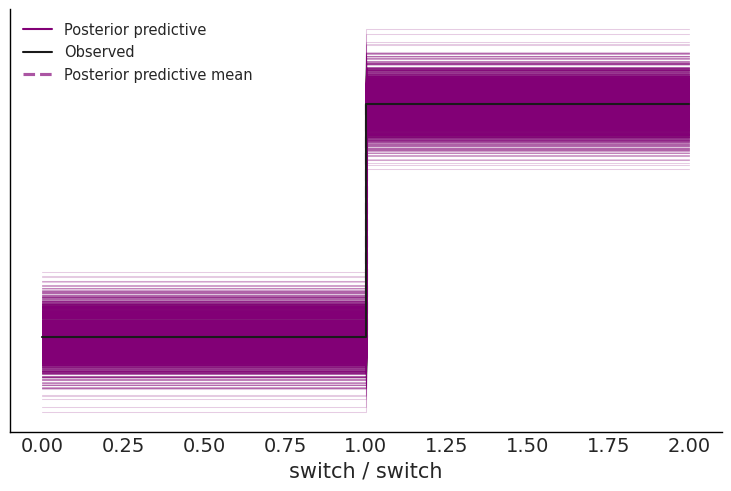

In [ ]:
az.plot_ppc(m4_fit);

In [ ]:
loo4 = az.loo(m4_fit)
loo4

Computed from 2000 posterior samples and 3020 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1968.44    15.69
p_loo        3.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

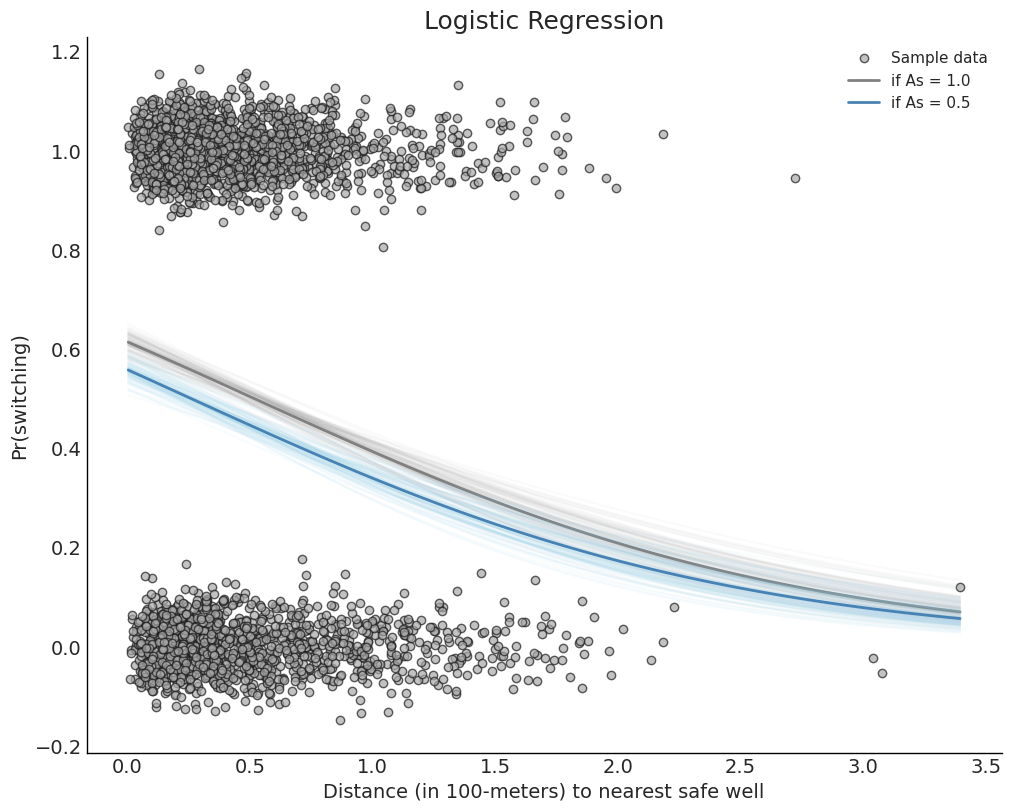

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['dist100'].min(), wells['dist100'].max(), 100), dims=["x_plot"])
plt.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# As = 1.0: Posterior regression lines
mu_pred_As1 = m4_fit.posterior["Intercept"] + (m4_fit.posterior["dist100"] * x_axis) + (m4_fit.posterior["arsenic"] * 1.0)
mu_mean_As1 = mu_pred_As1.mean(dim=("chain", "draw"))
mu_plot_As1 = mu_pred_As1.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As1.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As1.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As1), color="gray", lw=2.0, label='if As = 1.0')

# As = 0.5: Posterior regression lines
mu_pred_As0pt5 = m4_fit.posterior["Intercept"] + (m4_fit.posterior["dist100"] * x_axis) + (m4_fit.posterior["arsenic"] * 0.5)
mu_mean_As0pt5 = mu_pred_As0pt5.mean(dim=("chain", "draw"))
mu_plot_As0pt5 = mu_pred_As0pt5.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As0pt5.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As0pt5.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As0pt5), color="steelblue", lw=2.0, label='if As = 0.5')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

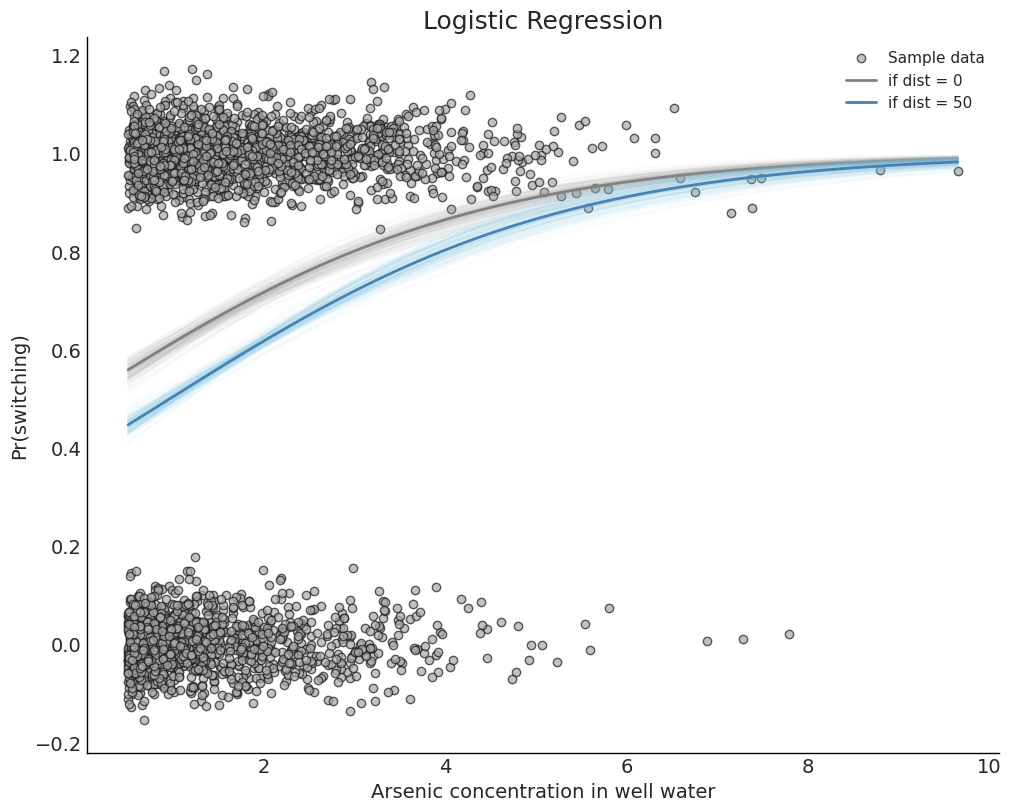

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 100), dims=["x_plot"])
plt.scatter(wells.arsenic, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# dist = 0 meters: Posterior regression lines
mu_pred_dist0 = m4_fit.posterior["Intercept"] + (m4_fit.posterior["dist100"] * 0.0) + (m4_fit.posterior["arsenic"] * x_axis)
mu_mean_dist0 = mu_pred_dist0.mean(dim=("chain", "draw"))
mu_plot_dist0 = mu_pred_dist0.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist0.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist0.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist0), color="gray", lw=2.0, label='if dist = 0')

# dist = 50 meters: Posterior regression lines
mu_pred_dist50 = m4_fit.posterior["Intercept"] + (m4_fit.posterior["dist100"] * 0.5) + (m4_fit.posterior["arsenic"] * x_axis)
mu_mean_dist50 = mu_pred_dist50.mean(dim=("chain", "draw"))
mu_plot_dist50 = mu_pred_dist50.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist50.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist50.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist50), color="steelblue", lw=2.0, label='if dist = 50')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Arsenic concentration in well water', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

---

# Compare models

In [ ]:
compare_dict = {"Model 1": loo1, "Model 2": loo2, "Model 3": loo3, "Model 4": loo4}

az.compare(compare_dict).round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se    dse  warning scale
Model 4     0  -1968.44   3.22       0.00    0.87  15.69   0.00    False   log
Model 2     1  -2021.65   2.04      53.21    0.13  11.95  11.95    False   log
Model 3     2  -2040.05   1.92      71.61    0.00  10.42  12.19    False   log
Model 1     3  -2060.05   1.00      91.61    0.00   8.25  13.64    False   log

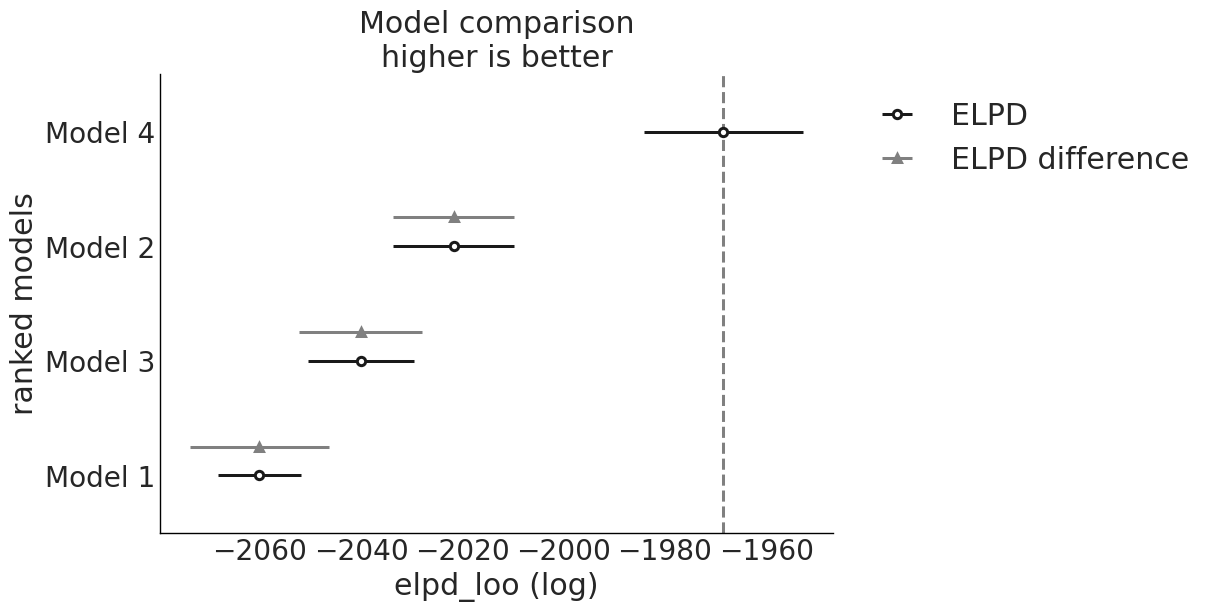

In [ ]:
az.plot_compare(az.compare(compare_dict), figsize=(12, 6));

---

# Exercise:

### Estimate the relationship between `income as a binary variable (either below or above 50K per year)` and two predictors, `sex` and `hours of work per week`, in a sample of adults from 1994 [[Source]](https://bambinos.github.io/bambi/notebooks/model_comparison.html)

### Read dataset into DataFrame

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2024ODSCEast/main/data/adults.csv')

### Pre-process data

In [ ]:
categorical_cols = d.columns[d.dtypes == object].tolist()
for col in categorical_cols:
    d[col] = d[col].astype("category")

In [ ]:
d.dtypes

income     category
sex        category
race       category
age           int64
hs_week       int64
dtype: object

In [ ]:
d2 = d[d["race"].isin(["Black", "White"])]
d2["race"] = d2["race"].cat.remove_unused_categories()

age_bins = [17, 25, 35, 45, 65, 90]
d2["age_binned"] = pd.cut(d2["age"], age_bins)

hours_bins = [0, 20, 40, 60, 100]
d2["hs_week_binned"] = pd.cut(d2["hs_week"], hours_bins)

d2['female'] = np.where(d2.sex == 'Female', 1, 0)

d2

income     sex   race  age  hs_week age_binned hs_week_binned  female
0      <=50K    Male  White   39       40   (35, 45]       (20, 40]       0
1      <=50K    Male  White   50       13   (45, 65]        (0, 20]       0
2      <=50K    Male  White   38       40   (35, 45]       (20, 40]       0
3      <=50K    Male  Black   53       40   (45, 65]       (20, 40]       0
4      <=50K  Female  Black   28       40   (25, 35]       (20, 40]       1
...      ...     ...    ...  ...      ...        ...            ...     ...
32556  <=50K  Female  White   27       38   (25, 35]       (20, 40]       1
32557   >50K    Male  White   40       40   (35, 45]       (20, 40]       0
32558  <=50K  Female  White   58       40   (45, 65]       (20, 40]       1
32559  <=50K    Male  White   22       20   (17, 25]        (0, 20]       0
32560   >50K  Female  White   52       40   (45, 65]       (20, 40]       1

[30940 rows x 8 columns]

In [ ]:
age_mean = np.mean(d2["age"])
age_std = np.std(d2["age"])

hs_mean = np.mean(d2["hs_week"])
hs_std = np.std(d2["hs_week"])

d2["age"] = (d2["age"] - age_mean) / age_std
d2["hs_week"] = (d2["hs_week"] - hs_mean) / hs_std

d2

income     sex   race       age   hs_week age_binned hs_week_binned  \
0      <=50K    Male  White  0.024207 -0.037250   (35, 45]       (20, 40]   
1      <=50K    Male  White  0.827984 -2.222326   (45, 65]        (0, 20]   
2      <=50K    Male  White -0.048863 -0.037250   (35, 45]       (20, 40]   
3      <=50K    Male  Black  1.047195 -0.037250   (45, 65]       (20, 40]   
4      <=50K  Female  Black -0.779569 -0.037250   (25, 35]       (20, 40]   
...      ...     ...    ...       ...       ...        ...            ...   
32556  <=50K  Female  White -0.852640 -0.199107   (25, 35]       (20, 40]   
32557   >50K    Male  White  0.097278 -0.037250   (35, 45]       (20, 40]   
32558  <=50K  Female  White  1.412548 -0.037250   (45, 65]       (20, 40]   
32559  <=50K    Male  White -1.217993 -1.655825   (17, 25]        (0, 20]   
32560   >50K  Female  White  0.974125 -0.037250   (45, 65]       (20, 40]   

       female  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
32556       1  
32557       0  
32558       1  
32559       0  
32560       1  

[30940 rows x 8 columns]

### Plot data

In [ ]:
mpl.style.use('tableau-colorblind10')

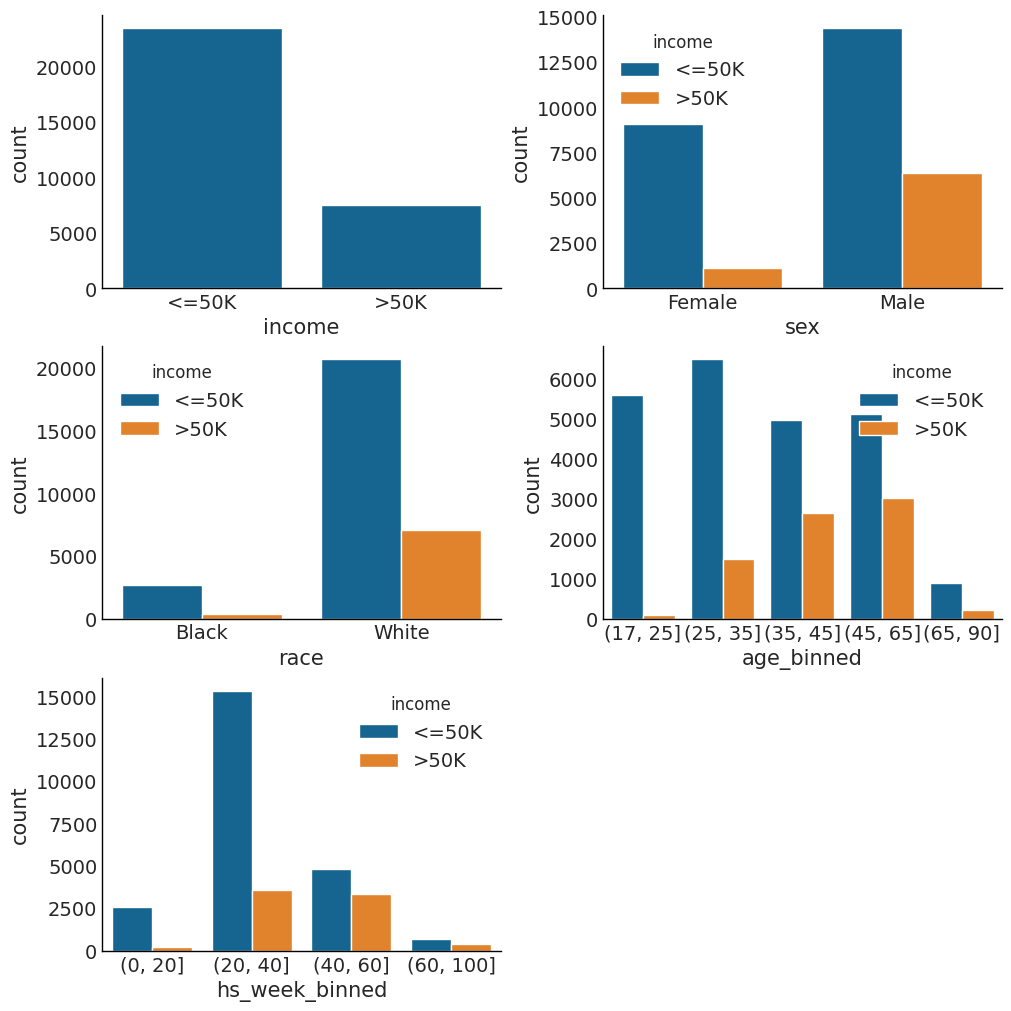

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.countplot(x="income", color="C0", data=d2, ax=axes[0, 0])
sns.countplot(x="sex", hue="income", data=d2, ax=axes[0, 1])
sns.countplot(x="race", hue="income", data=d2, ax=axes[1, 0])
sns.countplot(x="age_binned", hue="income", data=d2, ax=axes[1, 1])
sns.countplot(x="hs_week_binned", hue="income", data=d2, ax=axes[2, 0])
axes[2, 1].axis("off");

### Plot model

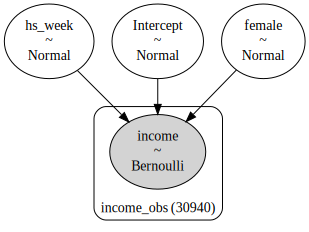

       Formula: income['>50K'] ~ 1 + female + hs_week
        Family: bernoulli
          Link: p = logit
  Observations: 30940
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.0533)
            female ~ Normal(mu: 0.0, sigma: 5.3185)
            hs_week ~ Normal(mu: 0.0, sigma: 2.5)

### Plot prior parameter distributions

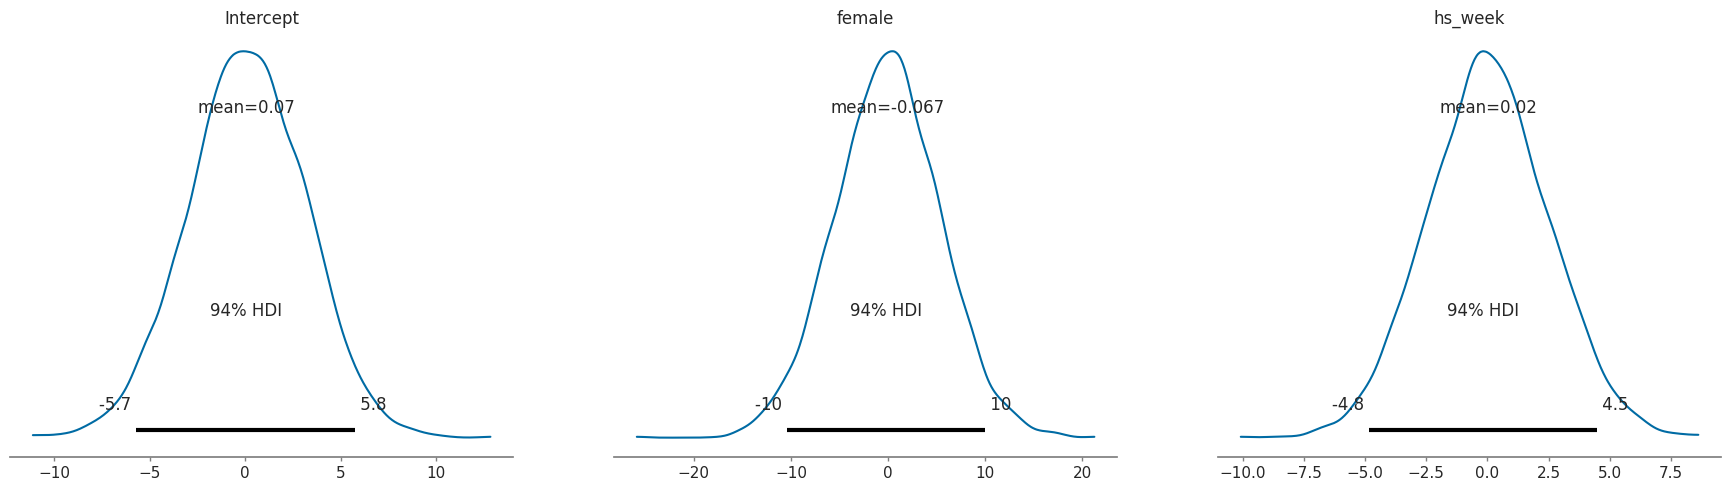

### Fit model

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Plot MCMC diagnostics

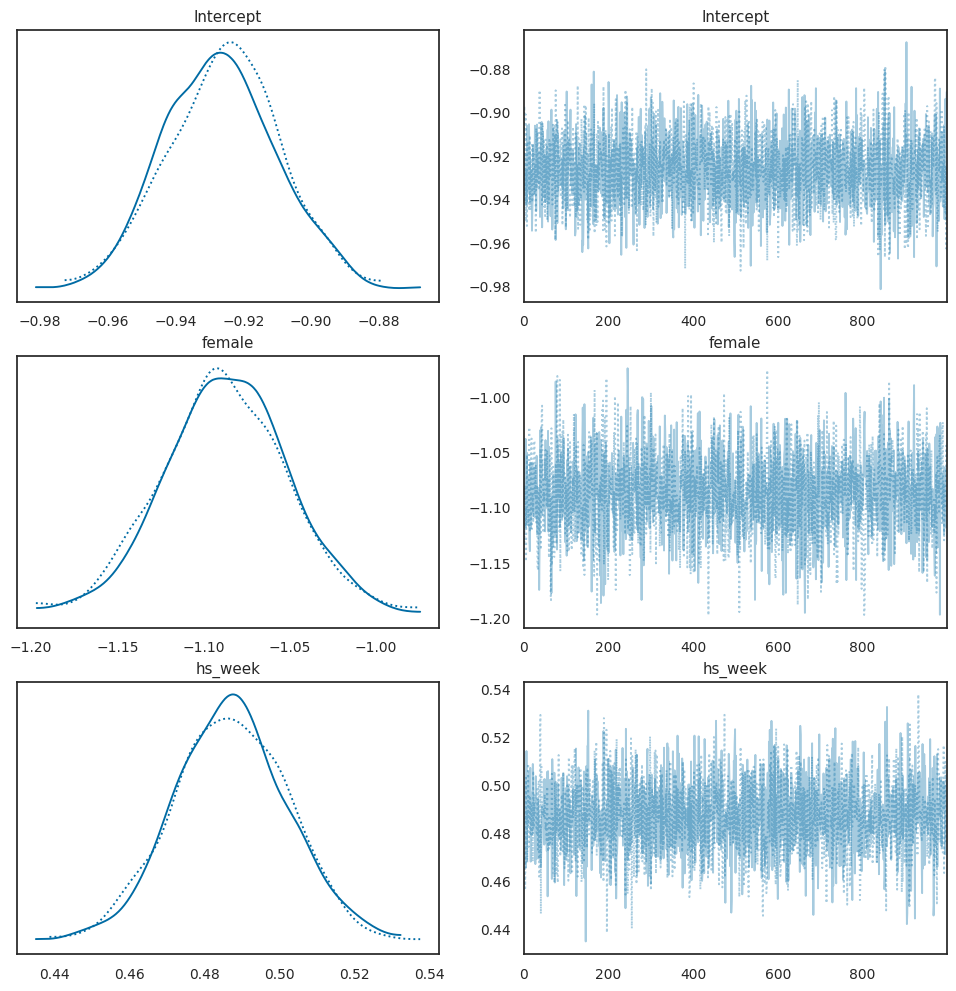

### Plot posterior distributions

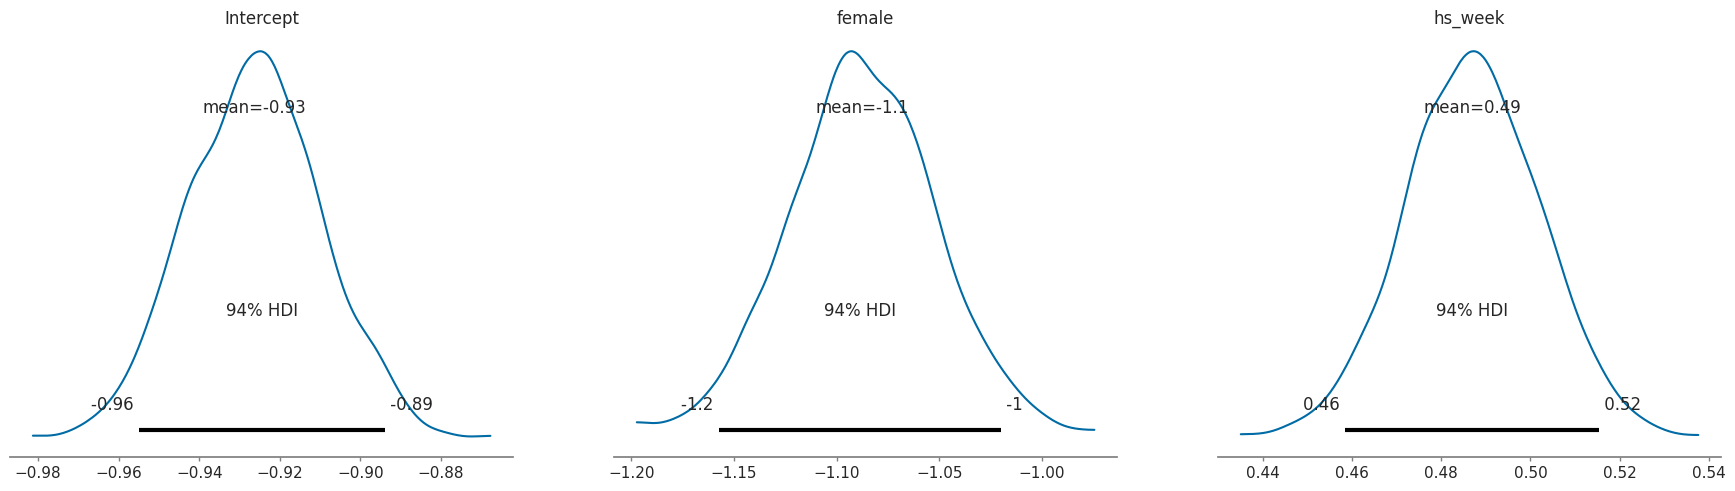

### Interpret results

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept  -0.9  0.0    -1.0     -0.9        0.0      0.0    2565.0    1529.0   
female     -1.1  0.0    -1.2     -1.0        0.0      0.0    2194.0    1723.0   
hs_week     0.5  0.0     0.5      0.5        0.0      0.0    2757.0    1748.0   

           r_hat  
Intercept    1.0  
female       1.0  
hs_week      1.0

### Plot posterior predictive distribution

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

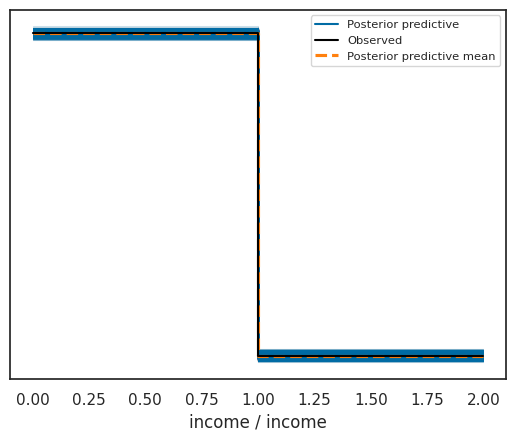

### Compute loo

Computed from 2000 posterior samples and 30940 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15769.55    90.22
p_loo        3.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     30940  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

---